In [1]:
import os, sys
cur_dir = os.getcwd()
basename = os.path.basename(cur_dir)
for _ in range(5):
    if basename != 'OCLog':
        cur_dir = os.path.dirname(cur_dir)
        basename = os.path.basename(cur_dir)
        #print(cur_dir, basename)
    else:
        if cur_dir not in sys.path:
            sys.path.append(cur_dir)
            #print(sys.path)
import os
from openpyxl import Workbook
from openpyxl import load_workbook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import trange, tqdm, tnrange
from oclog.BGL.bglogUKC import BGLog, get_embedding_layer
from oclog.openset.boundary_loss import euclidean_metric, BoundaryLoss
from oclog.openset.pretraining import LogLineEncoder, LogSeqEncoder, LogClassifier
# from oclog.openset.openset import OpenSet
from oclog.openset.opensetv6 import OpenSet
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import sklearn.metrics as m
import warnings
warnings.filterwarnings('ignore')
def update_tracker(file_name, data):
    if os.path.exists(file_name):
        wb = load_workbook(file_name)
    else:
        wb = Workbook()    
    wb.save(file_name)
    # wb.close(file_name)
    orig_df = pd.read_excel(file_name,)
    #print(orig_df.head())
    new_df = pd.DataFrame(data, )
    concat_df = pd.concat([orig_df, new_df], axis=0)
    #print(concat_df.head())
    concat_df.to_excel(file_name)
    return concat_df

def oset_train(ablation=5000,designated_ukc_cls=3,num_classes=2,embedding_size=128,lr_rate=3,optimizer='sgd',
pretrain_epochs=3,octrain_epochs=200,wait_patience=3, debug=False, tracker='tracker.xlsx', comment='',
             tracker_update=True):
    tf.random.set_seed(1234)
    np.random.seed(1234) 
    bglog = BGLog(save_padded_num_sequences=False, debug=debug,  load_from_pkl=True, )
    train_test = bglog.get_tensor_train_val_test(ablation=ablation, designated_ukc_cls=designated_ukc_cls )
    train_data, val_data, test_data = train_test
    line_encoder = LogLineEncoder(bglog, chars_in_line=64)
    logSeqencer =  LogSeqEncoder(line_in_seq=32, dense_neurons=embedding_size)
    ptmodel = LogClassifier(line_encoder=line_encoder, seq_encoder=logSeqencer, num_classes=num_classes)
    ptmodel.compile(optimizer='adam', loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    hist = ptmodel.fit(train_data, validation_data=val_data, epochs=pretrain_epochs)    
    pre_tr_acc = hist.history.get('accuracy')[len(hist.history.get('accuracy'))-1]
    # print(round(pre_tr_acc, 4))
    pre_val_acc = hist.history.get('val_accuracy')[len(hist.history.get('val_accuracy'))-1]
    # print(round(pre_val_acc, 4))
    oset = OpenSet(num_classes, ptmodel, embedding_size=embedding_size)
    _, _ = oset.train(train_data,data_val=val_data, epochs=octrain_epochs, 
                      lr_rate=lr_rate, wait_patience=wait_patience, optimizer=optimizer,
                     pretrain_hist=hist)
    _, _, f1_weighted, f_measure = oset.evaluate(test_data, ukc_label=designated_ukc_cls)
    lst = list(tf.reshape(oset.radius, (1, num_classes)).numpy()[0])
    lst = [str(i) for i in lst]
    radius = ','.join(lst)    
    loss = oset.losses[len(oset.losses)-1].numpy()    
    tracker_data = {'ablation':[ablation],'designated_ukc_cls': [designated_ukc_cls],'num_classes': [num_classes],
                   'embedding_size': [embedding_size], 'lr_rate': [lr_rate], 'optimizer': [optimizer],
                    'pretrain_epochs': [pretrain_epochs],'octrain_epochs': [oset.epoch], 'wait_patience': [wait_patience], 
                   'f1_weighted': [f1_weighted], 'f1_macro': f_measure.get('F1-score'), 
                   'F1Known': f_measure.get('Known'), 'F1Open': f_measure.get('Open'), 'loss':[loss], 'Radius': radius,
                   'pre_tr_acc': pre_tr_acc, 'pre_val_acc': pre_val_acc,'comment': comment}
    
    if tracker_update:
        update_tracker(tracker, tracker_data)
    return test_data, oset, hist

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 3200
val_0:, 400
test_0:, 400
train_1:, 3200
val_1:, 400
test_1:, 400
train_2:, 3200
val_2:, 400
test_2:, 400
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/5
300/300 [==============================] - 30s 98ms/step - loss: 0.0388 - accuracy: 0.9890 - precision: 0.9956 - recall: 0.9789 - val_loss: 0.0172 - val_accuracy: 0.9916 - val_precision: 0.9916 - val_recall: 0.9916
Epoch 2/5
300/300 [==============================] - 30s 99ms/step - loss: 0.0061 - accuracy: 0.9985 - precision: 0.9989 - recall: 0.9984 - val_loss: 2.4336e-05 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/5
300/300 [==============================] - 29s 96ms/step - loss: 2.3015e-05 - accuracy: 1.0000 - precision: 1.0000 - recall: 1.0000 - val_loss: 3.4589e-05 - val_accuracy: 1.0000 - v

100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.34it/s]


epoch: 1/200, train_loss: 3.422283411026001, F1_train: 0.9260697463114775 F1_val: 0.9772325900412198


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.48it/s]


epoch: 2/200, train_loss: 3.4223079681396484, F1_train: 0.9363944603169785 F1_val: 0.979972619678502


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.49it/s]


epoch: 3/200, train_loss: 3.422316551208496, F1_train: 0.9388232555696948 F1_val: 0.9831041720450903


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.49it/s]


epoch: 4/200, train_loss: 3.422267198562622, F1_train: 0.9397243204305935 F1_val: 0.9870861820171981


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.49it/s]


epoch: 5/200, train_loss: 3.42232346534729, F1_train: 0.9406567082263363 F1_val: 0.9870851037893563


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.46it/s]


epoch: 6/200, train_loss: 3.4222021102905273, F1_train: 0.9414416260614867 F1_val: 0.9883976073466422


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.46it/s]


epoch: 7/200, train_loss: 3.422271251678467, F1_train: 0.9417812057205314 F1_val: 0.9888348918983717


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.46it/s]


epoch: 8/200, train_loss: 3.4223055839538574, F1_train: 0.9419573650152161 F1_val: 0.9897035067763761


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.46it/s]


epoch: 9/200, train_loss: 3.422309637069702, F1_train: 0.9422247050848026 F1_val: 0.9897043356635259


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:42<00:00,  7.14it/s]


epoch: 10/200, train_loss: 3.4222986698150635, F1_train: 0.9422768291324128 F1_val: 0.9910051072853234


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.39it/s]


epoch: 11/200, train_loss: 3.422259569168091, F1_train: 0.9423354904858274 F1_val: 0.9910059595404423


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.39it/s]


epoch: 12/200, train_loss: 3.4222664833068848, F1_train: 0.9423941323891912 F1_val: 0.9914354710333813


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.40it/s]


epoch: 13/200, train_loss: 3.422229766845703, F1_train: 0.9423941323891912 F1_val: 0.9914354347665668
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.34it/s]


epoch: 14/200, train_loss: 3.422279119491577, F1_train: 0.9423941323891912 F1_val: 0.9914356730280307


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.39it/s]


epoch: 15/200, train_loss: 3.422257423400879, F1_train: 0.9423941323891912 F1_val: 0.991435875863026


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.32it/s]


epoch: 16/200, train_loss: 3.4222681522369385, F1_train: 0.9423941323891912 F1_val: 0.9918651091280193


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:39<00:00,  7.55it/s]


epoch: 17/200, train_loss: 3.422292470932007, F1_train: 0.9423941323891912 F1_val: 0.9918650595341513
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:39<00:00,  7.60it/s]


epoch: 18/200, train_loss: 3.422229051589966, F1_train: 0.9423941323891912 F1_val: 0.99186529535192


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:39<00:00,  7.60it/s]


epoch: 19/200, train_loss: 3.422305107116699, F1_train: 0.9424462401454912 F1_val: 0.9918641535907408


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:39<00:00,  7.57it/s]


epoch: 20/200, train_loss: 3.4222941398620605, F1_train: 0.9424462401454912 F1_val: 0.9923008929993007


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.37it/s]


epoch: 21/200, train_loss: 3.4223062992095947, F1_train: 0.9424462401454912 F1_val: 0.9918645842377946
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.41it/s]


epoch: 22/200, train_loss: 3.422290802001953, F1_train: 0.9424462401454912 F1_val: 0.9922929075506596
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.27it/s]


epoch: 23/200, train_loss: 3.422271251678467, F1_train: 0.9424462401454912 F1_val: 0.9918652564029745
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.01it/s]


epoch: 24/200, train_loss: 3.422287702560425, F1_train: 0.9425048626084758 F1_val: 0.9918651584695013


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:43<00:00,  6.94it/s]


epoch: 25/200, train_loss: 3.422290563583374, F1_train: 0.9425048626084758 F1_val: 0.9918654801137197
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:44<00:00,  6.77it/s]


epoch: 26/200, train_loss: 3.422294855117798, F1_train: 0.9425048626084758 F1_val: 0.9918646831731448
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.30it/s]


epoch: 27/200, train_loss: 3.422264337539673, F1_train: 0.9425048626084758 F1_val: 0.9918651953992397
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.18it/s]


epoch: 28/200, train_loss: 3.422244071960449, F1_train: 0.9425048626084758 F1_val: 0.9918647322641626
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.23it/s]


epoch: 29/200, train_loss: 3.4222936630249023, F1_train: 0.9425048626084758 F1_val: 0.9918651091280193
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:42<00:00,  7.13it/s]


epoch: 30/200, train_loss: 3.4222819805145264, F1_train: 0.9425048626084758 F1_val: 0.9923008929993007
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:40<00:00,  7.40it/s]


epoch: 31/200, train_loss: 3.42228102684021, F1_train: 0.9425048626084758 F1_val: 0.9922930772819538
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 300/300 [00:41<00:00,  7.18it/s]


epoch: 32/200, train_loss: 3.422279119491577, F1_train: 0.9425048626084758 F1_val: 0.9918649705256265
train score not improving  going to wait state 8
val score not improving  going to wait state 8


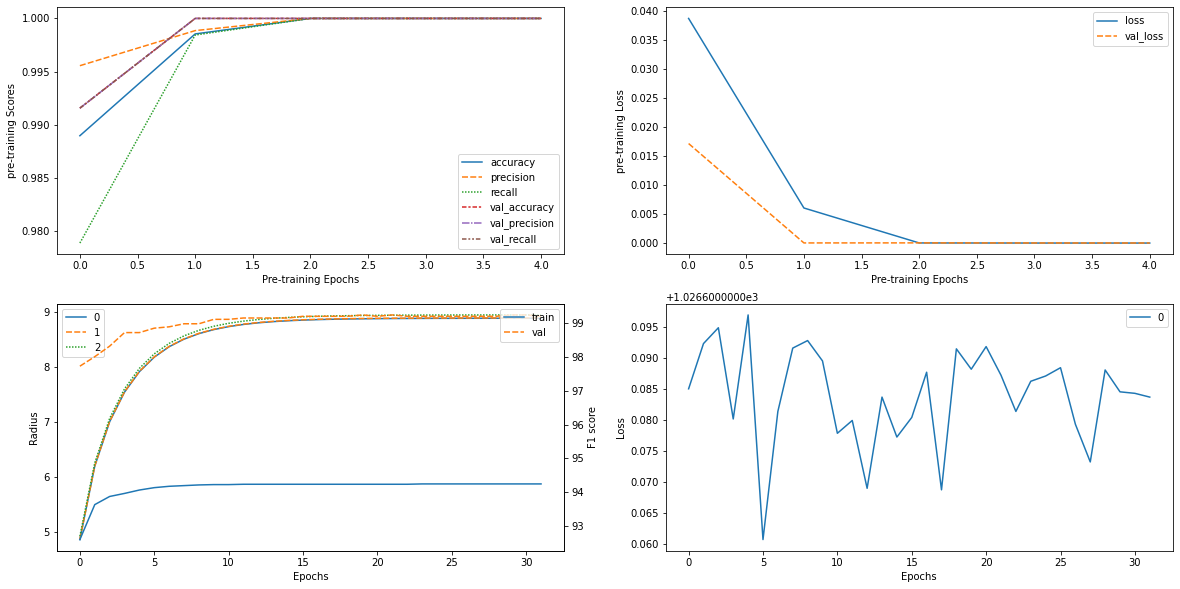

[[392   0   0   4]
 [  0 392   0   0]
 [  0   0 379  14]
 [  0   0   0 163]]
98.66
f1_weighted: 0.9868555319517208, f1_macro: 0.9811158903616911, f1_micro: 0.9866071428571429, f_measure: {'Known': 99.2263, 'Open': 94.7674, 'F1-score': 98.1116}
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       396
           1       1.00      1.00      1.00       392
           2       1.00      0.96      0.98       393
           5       0.90      1.00      0.95       163

    accuracy                           0.99      1344
   macro avg       0.98      0.99      0.98      1344
weighted avg       0.99      0.99      0.99      1344



In [2]:
comment="em size 16 with 3000 99pct, now lets go for 4000 data"
test_data, oset, hist = oset_train(ablation=4000,designated_ukc_cls=5,num_classes=3,embedding_size=16,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=5, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 4000
val_0:, 500
test_0:, 500
train_1:, 4000
val_1:, 500
test_1:, 500
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/5
250/250 [==============================] - 25s 98ms/step - loss: 0.0215 - accuracy: 0.9944 - precision_1: 0.9944 - recall_1: 0.9944 - val_loss: 1.6597e-04 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 2/5
250/250 [==============================] - 24s 97ms/step - loss: 7.2735e-06 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 5.9618e-05 - val_accuracy: 1.0000 - val_precision_1: 1.0000 - val_recall_1: 1.0000
Epoch 3/5
250/250 [==============================] - 24s 97ms/step - loss: 3.5522e-06 - accuracy: 1.0000 - precision_1: 1.0000 - recall_1: 1.0000 - val_loss: 3.5944e-05 - val_accuracy: 1.0000 - val_precision

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.27it/s]


epoch: 1/200, train_loss: 2.979459524154663, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.21it/s]


epoch: 2/200, train_loss: 2.9794485569000244, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.32it/s]


epoch: 3/200, train_loss: 2.9794559478759766, F1_train: 0.9542229499249556 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.31it/s]


epoch: 4/200, train_loss: 2.979464054107666, F1_train: 0.9542229499249556 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.31it/s]


epoch: 5/200, train_loss: 2.9794561862945557, F1_train: 0.9542229499249556 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.29it/s]


epoch: 6/200, train_loss: 2.979437828063965, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.29it/s]


epoch: 7/200, train_loss: 2.979454278945923, F1_train: 0.9542974079126875 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.28it/s]


epoch: 8/200, train_loss: 2.9794583320617676, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.20it/s]


epoch: 9/200, train_loss: 2.9794423580169678, F1_train: 0.9542974079126875 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  6.95it/s]


epoch: 10/200, train_loss: 2.979459047317505, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.24it/s]


epoch: 11/200, train_loss: 2.9794583320617676, F1_train: 0.9542974079126875 F1_val: 1.0
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.26it/s]


epoch: 12/200, train_loss: 2.979445457458496, F1_train: 0.9543718455872323 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.27it/s]


epoch: 13/200, train_loss: 2.979464292526245, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.27it/s]


epoch: 14/200, train_loss: 2.9794485569000244, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.28it/s]


epoch: 15/200, train_loss: 2.979459762573242, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.25it/s]


epoch: 16/200, train_loss: 2.9794528484344482, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.27it/s]


epoch: 17/200, train_loss: 2.979450225830078, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.17it/s]


epoch: 18/200, train_loss: 2.9794468879699707, F1_train: 0.9545206600300014 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.28it/s]


epoch: 19/200, train_loss: 2.979459047317505, F1_train: 0.9545206600300014 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.23it/s]


epoch: 20/200, train_loss: 2.9794602394104004, F1_train: 0.9545206600300014 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.27it/s]


epoch: 21/200, train_loss: 2.979457139968872, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.15it/s]


epoch: 22/200, train_loss: 2.979461669921875, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.25it/s]


epoch: 23/200, train_loss: 2.9794604778289795, F1_train: 0.9545950368148352 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.22it/s]


epoch: 24/200, train_loss: 2.979451894760132, F1_train: 0.9545950368148352 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.18it/s]


epoch: 25/200, train_loss: 2.979459524154663, F1_train: 0.49128831234897624 F1_val: 0.43572241183162685
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.28it/s]


epoch: 26/200, train_loss: 2.979452133178711, F1_train: 0.49128831234897624 F1_val: 0.43495512561150557
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.31it/s]


epoch: 27/200, train_loss: 2.9794507026672363, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.24it/s]


epoch: 28/200, train_loss: 2.979442834854126, F1_train: 0.49128831234897624 F1_val: 0.43636363636363634
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.37it/s]


epoch: 29/200, train_loss: 2.9794411659240723, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.35it/s]


epoch: 30/200, train_loss: 2.979451894760132, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.35it/s]


epoch: 31/200, train_loss: 2.9794492721557617, F1_train: 0.9546693933197 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.36it/s]


epoch: 32/200, train_loss: 2.9794561862945557, F1_train: 0.9546693933197 F1_val: 1.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.37it/s]


epoch: 33/200, train_loss: 2.9794492721557617, F1_train: 0.49128831234897624 F1_val: 0.43495512561150557
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.38it/s]


epoch: 34/200, train_loss: 2.979468584060669, F1_train: 0.9546693933197 F1_val: 1.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.30it/s]


epoch: 35/200, train_loss: 2.97945499420166, F1_train: 0.9546693933197 F1_val: 1.0
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.37it/s]


epoch: 36/200, train_loss: 2.979461431503296, F1_train: 0.9546693933197 F1_val: 1.0
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.36it/s]


epoch: 37/200, train_loss: 2.9794626235961914, F1_train: 0.9546693933197 F1_val: 1.0
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:35<00:00,  7.10it/s]


epoch: 38/200, train_loss: 2.9794352054595947, F1_train: 0.9546693933197 F1_val: 1.0
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.37it/s]


epoch: 39/200, train_loss: 2.9794561862945557, F1_train: 0.9546693933197 F1_val: 1.0
train score not improving  going to wait state 8
val score not improving  going to wait state 8


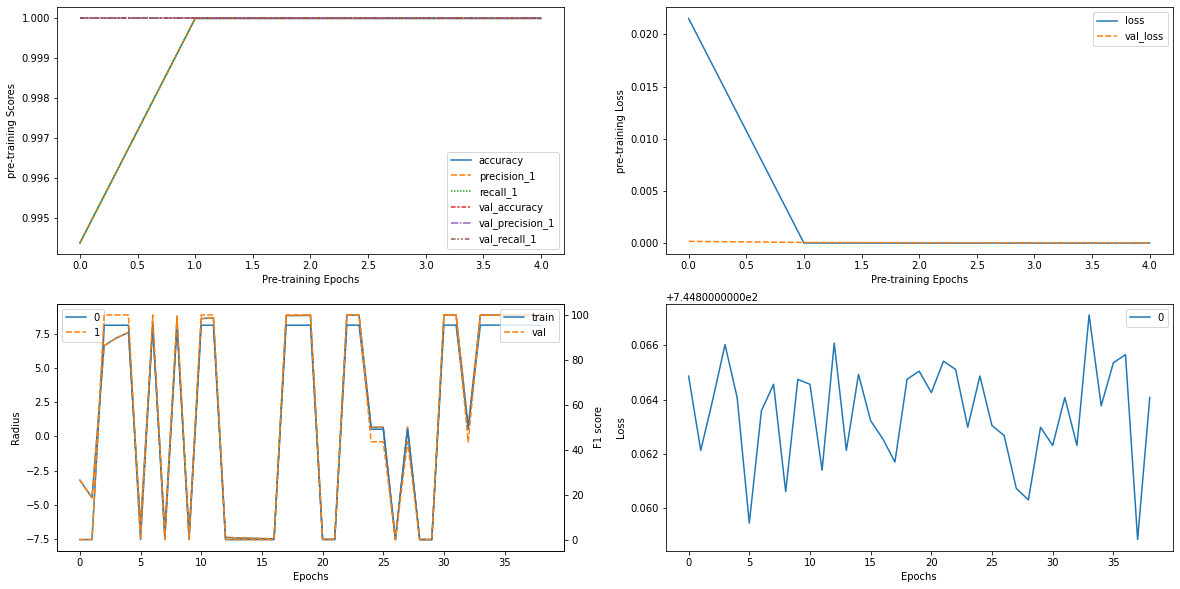

[[493   0   0]
 [  0 496   0]
 [  2   0 161]]
99.83
f1_weighted: 0.9982602877187428, f1_macro: 0.9972676229986172, f1_micro: 0.9982638888888888, f_measure: {'Known': 99.8988, 'Open': 99.3827, 'F1-score': 99.7268}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       493
           1       1.00      1.00      1.00       496
           5       1.00      0.99      0.99       163

    accuracy                           1.00      1152
   macro avg       1.00      1.00      1.00      1152
weighted avg       1.00      1.00      1.00      1152



In [3]:
comment="em size 16 with 3000 99pct, now lets go for 4000 data"
test_data, oset, hist = oset_train(ablation=5000,designated_ukc_cls=5,num_classes=2,embedding_size=16,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=5, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 4000
val_0:, 500
test_0:, 500
train_1:, 4000
val_1:, 500
test_1:, 500
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
250/250 [==============================] - 24s 95ms/step - loss: 0.0215 - accuracy: 0.9944 - precision_2: 0.9944 - recall_2: 0.9944 - val_loss: 1.6597e-04 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 2/10
250/250 [==============================] - 24s 94ms/step - loss: 7.2735e-06 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - val_loss: 5.9618e-05 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - val_recall_2: 1.0000
Epoch 3/10
250/250 [==============================] - 24s 95ms/step - loss: 3.5522e-06 - accuracy: 1.0000 - precision_2: 1.0000 - recall_2: 1.0000 - val_loss: 3.5944e-05 - val_accuracy: 1.0000 - val_precis

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.51it/s]


epoch: 1/200, train_loss: 3.0909032821655273, F1_train: 0.9542229499249556 F1_val: 0.9854746110849215


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.54it/s]


epoch: 2/200, train_loss: 3.0909223556518555, F1_train: 0.4873766500064078 F1_val: 0.43905139420448336
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.54it/s]


epoch: 3/200, train_loss: 3.0909063816070557, F1_train: 0.9542229499249556 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.50it/s]


epoch: 4/200, train_loss: 3.090902328491211, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.45it/s]


epoch: 5/200, train_loss: 3.090904474258423, F1_train: 0.9542229499249556 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.56it/s]


epoch: 6/200, train_loss: 3.0909054279327393, F1_train: 0.9542229499249556 F1_val: 1.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.56it/s]


epoch: 7/200, train_loss: 3.0909104347229004, F1_train: 0.9542229499249556 F1_val: 1.0
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.56it/s]


epoch: 8/200, train_loss: 3.090911865234375, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.50it/s]


epoch: 9/200, train_loss: 3.0909078121185303, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.41it/s]


epoch: 10/200, train_loss: 3.090918779373169, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.54it/s]


epoch: 11/200, train_loss: 3.0909008979797363, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 8
val score not improving  going to wait state 8


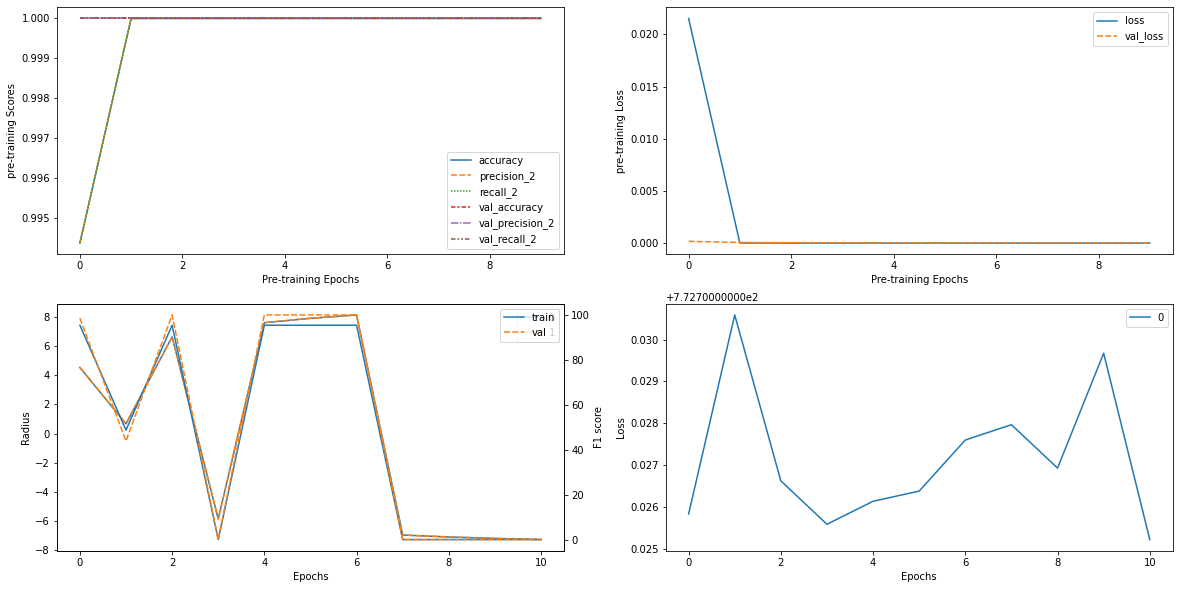

[[493   0   0]
 [  0 496   0]
 [  0   0 163]]
100.0
f1_weighted: 1.0, f1_macro: 1.0, f1_micro: 1.0, f_measure: {'Known': 100.0, 'Open': 100.0, 'F1-score': 100.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       493
           1       1.00      1.00      1.00       496
           5       1.00      1.00      1.00       163

    accuracy                           1.00      1152
   macro avg       1.00      1.00      1.00      1152
weighted avg       1.00      1.00      1.00      1152



In [4]:
comment="500 data , more pre-training"
test_data, oset, hist = oset_train(ablation=5000,designated_ukc_cls=5,num_classes=2,embedding_size=16,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 4000
val_0:, 500
test_0:, 500
train_1:, 4000
val_1:, 500
test_1:, 500
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
250/250 [==============================] - 23s 90ms/step - loss: 0.0215 - accuracy: 0.9944 - precision_3: 0.9944 - recall_3: 0.9944 - val_loss: 1.6597e-04 - val_accuracy: 1.0000 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 2/10
250/250 [==============================] - 22s 89ms/step - loss: 7.2735e-06 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 5.9618e-05 - val_accuracy: 1.0000 - val_precision_3: 1.0000 - val_recall_3: 1.0000
Epoch 3/10
250/250 [==============================] - 22s 89ms/step - loss: 3.5522e-06 - accuracy: 1.0000 - precision_3: 1.0000 - recall_3: 1.0000 - val_loss: 3.5944e-05 - val_accuracy: 1.0000 - val_precis

100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.50it/s]


epoch: 1/200, train_loss: 3.0909032821655273, F1_train: 0.9542229499249556 F1_val: 0.9854746110849215


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.52it/s]


epoch: 2/200, train_loss: 3.0909223556518555, F1_train: 0.4873766500064078 F1_val: 0.43905139420448336
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.52it/s]


epoch: 3/200, train_loss: 3.0909063816070557, F1_train: 0.9542229499249556 F1_val: 1.0


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.52it/s]


epoch: 4/200, train_loss: 3.090902328491211, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.53it/s]


epoch: 5/200, train_loss: 3.090904474258423, F1_train: 0.9542229499249556 F1_val: 1.0
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.53it/s]


epoch: 6/200, train_loss: 3.0909054279327393, F1_train: 0.9542229499249556 F1_val: 1.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.53it/s]


epoch: 7/200, train_loss: 3.0909104347229004, F1_train: 0.9542229499249556 F1_val: 1.0
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.53it/s]


epoch: 8/200, train_loss: 3.090911865234375, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.53it/s]


epoch: 9/200, train_loss: 3.0909078121185303, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.53it/s]


epoch: 10/200, train_loss: 3.090918779373169, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 250/250 [00:33<00:00,  7.54it/s]


epoch: 11/200, train_loss: 3.0909008979797363, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 8
val score not improving  going to wait state 8


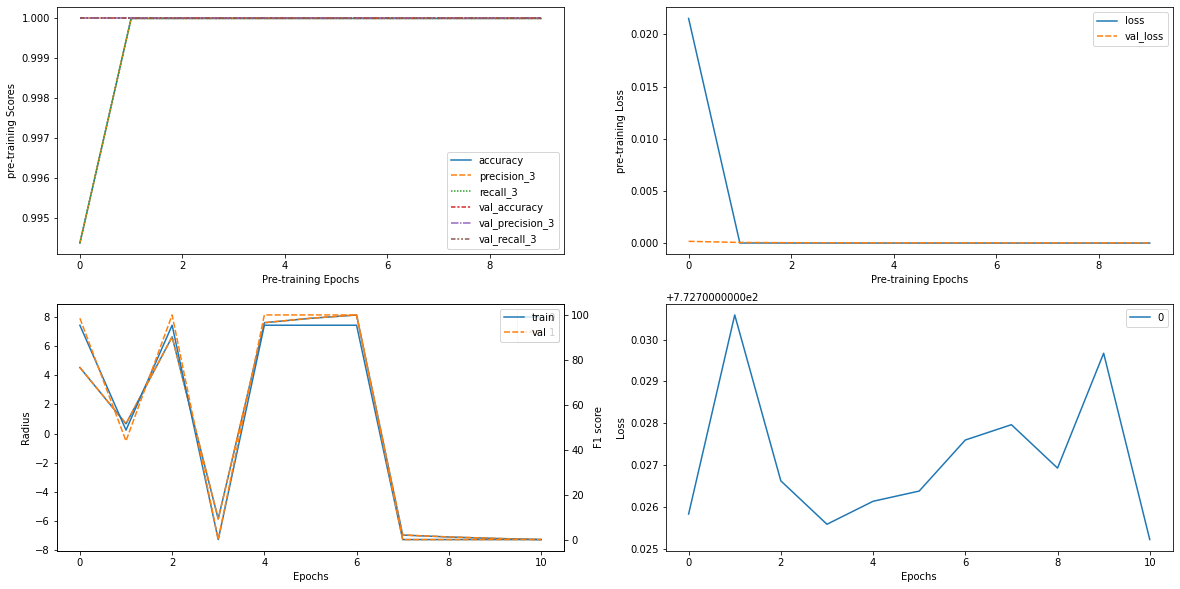

[[493   0   0]
 [  0 496   0]
 [  0   0 163]]
100.0
f1_weighted: 1.0, f1_macro: 1.0, f1_micro: 1.0, f_measure: {'Known': 100.0, 'Open': 100.0, 'F1-score': 100.0}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       493
           1       1.00      1.00      1.00       496
           5       1.00      1.00      1.00       163

    accuracy                           1.00      1152
   macro avg       1.00      1.00      1.00      1152
weighted avg       1.00      1.00      1.00      1152



In [5]:
comment="10000 data , more pre-training"
test_data, oset, hist = oset_train(ablation=5000,designated_ukc_cls=5,num_classes=2,embedding_size=16,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 8000
val_0:, 1000
test_0:, 1000
train_1:, 8000
val_1:, 1000
test_1:, 1000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
500/500 [==============================] - 45s 89ms/step - loss: 0.0142 - accuracy: 0.9958 - precision_4: 0.9958 - recall_4: 0.9958 - val_loss: 2.5907e-04 - val_accuracy: 1.0000 - val_precision_4: 1.0000 - val_recall_4: 1.0000
Epoch 2/10
500/500 [==============================] - 44s 89ms/step - loss: 0.0097 - accuracy: 0.9976 - precision_4: 0.9976 - recall_4: 0.9976 - val_loss: 0.0000e+00 - val_accuracy: 1.0000 - val_precision_4: 1.0000 - val_recall_4: 1.0000
Epoch 3/10
500/500 [==============================] - 45s 90ms/step - loss: 0.0207 - accuracy: 0.9983 - precision_4: 0.9983 - recall_4: 0.9983 - val_loss: 5.1487e-07 - val_accuracy: 1.0000 - val_precision_

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.55it/s]


epoch: 1/200, train_loss: 12.234259605407715, F1_train: 0.4228409293093202 F1_val: 0.33220311279471487


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.56it/s]


epoch: 2/200, train_loss: 12.234256744384766, F1_train: 0.4256641381514015 F1_val: 0.44989242560705855


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.52it/s]


epoch: 3/200, train_loss: 12.234257698059082, F1_train: 0.4270684682963804 F1_val: 0.4639992623345318


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.57it/s]


epoch: 4/200, train_loss: 12.234259605407715, F1_train: 0.42764408313834607 F1_val: 0.46743356029599586


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.57it/s]


epoch: 5/200, train_loss: 12.234261512756348, F1_train: 0.42809554241170217 F1_val: 0.46733249450427355


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.56it/s]


epoch: 6/200, train_loss: 12.234260559082031, F1_train: 0.5537777062729338 F1_val: 0.4688053365714495


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.42it/s]


epoch: 7/200, train_loss: 12.23425579071045, F1_train: 0.553941579689896 F1_val: 0.4701844093672281


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.55it/s]


epoch: 8/200, train_loss: 12.234258651733398, F1_train: 0.5539825333885045 F1_val: 0.469797817368994


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.55it/s]


epoch: 9/200, train_loss: 12.23426342010498, F1_train: 0.5540234812273762 F1_val: 0.4687204546570432


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.50it/s]


epoch: 10/200, train_loss: 12.234260559082031, F1_train: 0.5541053593309403 F1_val: 0.4684608346258759


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.52it/s]


epoch: 11/200, train_loss: 12.234256744384766, F1_train: 0.5541053593309403 F1_val: 0.4683153459142581
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.49it/s]


epoch: 12/200, train_loss: 12.23425579071045, F1_train: 0.5541053593309403 F1_val: 0.47085017637576654


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.53it/s]


epoch: 13/200, train_loss: 12.234258651733398, F1_train: 0.5542007566420191 F1_val: 0.4696819802400945


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.54it/s]


epoch: 14/200, train_loss: 12.234256744384766, F1_train: 0.5542007566420191 F1_val: 0.469827189370429
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.55it/s]


epoch: 15/200, train_loss: 12.234267234802246, F1_train: 0.5542007566420191 F1_val: 0.47002892331679846
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.55it/s]


epoch: 16/200, train_loss: 12.234265327453613, F1_train: 0.5542007566420191 F1_val: 0.4700584717369997
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.51it/s]


epoch: 17/200, train_loss: 12.234259605407715, F1_train: 0.5542007566420191 F1_val: 0.4706192562912061
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.38it/s]


epoch: 18/200, train_loss: 12.234248161315918, F1_train: 0.5542007566420191 F1_val: 0.47002892331679846
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.52it/s]


epoch: 19/200, train_loss: 12.234267234802246, F1_train: 0.5542007566420191 F1_val: 0.47024321642146594
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.53it/s]


epoch: 20/200, train_loss: 12.234261512756348, F1_train: 0.5542007566420191 F1_val: 0.4712093951858323


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.53it/s]


epoch: 21/200, train_loss: 12.234258651733398, F1_train: 0.5542007566420191 F1_val: 0.46964130249790526
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.54it/s]


epoch: 22/200, train_loss: 12.234257698059082, F1_train: 0.5542007566420191 F1_val: 0.4708911880405712
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.53it/s]


epoch: 23/200, train_loss: 12.23425579071045, F1_train: 0.5542007566420191 F1_val: 0.468856488507754
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.52it/s]


epoch: 24/200, train_loss: 12.234261512756348, F1_train: 0.5542007566420191 F1_val: 0.47123848768866317


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.53it/s]


epoch: 25/200, train_loss: 12.23426342010498, F1_train: 0.5542007566420191 F1_val: 0.4708215001051894
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.50it/s]


epoch: 26/200, train_loss: 12.234256744384766, F1_train: 0.5542007566420191 F1_val: 0.47073481151991586
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.54it/s]


epoch: 27/200, train_loss: 12.23426628112793, F1_train: 0.5542007566420191 F1_val: 0.46910864592720736
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.54it/s]


epoch: 28/200, train_loss: 12.234267234802246, F1_train: 0.5542007566420191 F1_val: 0.47108033601676463
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.53it/s]


epoch: 29/200, train_loss: 12.234261512756348, F1_train: 0.5542007566420191 F1_val: 0.47050351042633426
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.48it/s]


epoch: 30/200, train_loss: 12.234260559082031, F1_train: 0.5542007566420191 F1_val: 0.4725615988589434


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.47it/s]


epoch: 31/200, train_loss: 12.234254837036133, F1_train: 0.5542007566420191 F1_val: 0.4702142056040116
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.52it/s]


epoch: 32/200, train_loss: 12.234262466430664, F1_train: 0.5542007566420191 F1_val: 0.47123848768866317
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.53it/s]


epoch: 33/200, train_loss: 12.234260559082031, F1_train: 0.5542007566420191 F1_val: 0.4726298281278876


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.53it/s]


epoch: 34/200, train_loss: 12.234256744384766, F1_train: 0.5542007566420191 F1_val: 0.46922359112854567
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.53it/s]


epoch: 35/200, train_loss: 12.234259605407715, F1_train: 0.5542007566420191 F1_val: 0.4709192364981979
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.55it/s]


epoch: 36/200, train_loss: 12.234256744384766, F1_train: 0.5542007566420191 F1_val: 0.4725615988589434
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.52it/s]


epoch: 37/200, train_loss: 12.234254837036133, F1_train: 0.5542007566420191 F1_val: 0.4707062230228492
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.56it/s]


epoch: 38/200, train_loss: 12.234254837036133, F1_train: 0.5542007566420191 F1_val: 0.47040397238235876
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.54it/s]


epoch: 39/200, train_loss: 12.2342529296875, F1_train: 0.5542007566420191 F1_val: 0.4719142522167152
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.46it/s]


epoch: 40/200, train_loss: 12.23425579071045, F1_train: 0.5542007566420191 F1_val: 0.47031794273505045
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.56it/s]


epoch: 41/200, train_loss: 12.234257698059082, F1_train: 0.5542007566420191 F1_val: 0.4708215001051894
train score not improving  going to wait state 8
val score not improving  going to wait state 8


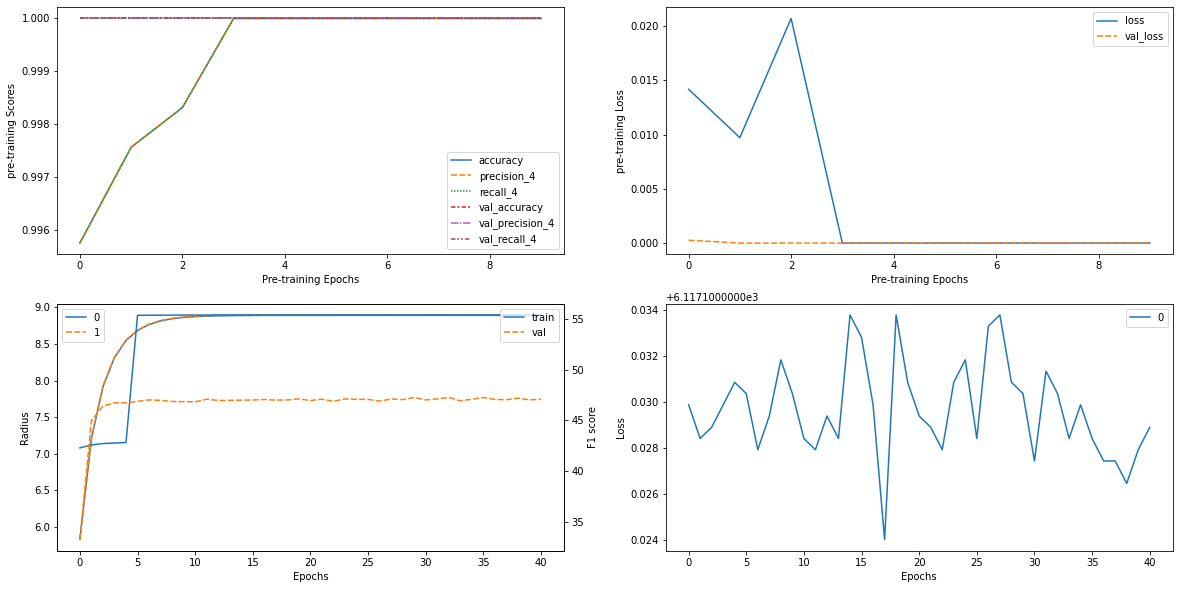

[[837   0 153]
 [  0  55 935]
 [  0   0 164]]
49.25
f1_weighted: 0.489408965923449, f1_macro: 0.41771924453643355, f1_micro: 0.4925373134328358, f_measure: {'Known': 51.076, 'Open': 23.1638, 'F1-score': 41.7719}
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       990
           1       1.00      0.06      0.11       990
           5       0.13      1.00      0.23       164

    accuracy                           0.49      2144
   macro avg       0.71      0.63      0.42      2144
weighted avg       0.93      0.49      0.49      2144



In [6]:
comment="10000 data , more pre-training"
test_data, oset, hist = oset_train(ablation=10000,designated_ukc_cls=5,num_classes=2,embedding_size=16,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 8000
val_0:, 1000
test_0:, 1000
train_1:, 8000
val_1:, 1000
test_1:, 1000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
500/500 [==============================] - 48s 94ms/step - loss: 0.0230 - accuracy: 0.9914 - precision_5: 0.9914 - recall_5: 0.9914 - val_loss: 1.3639e-07 - val_accuracy: 1.0000 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 2/10
500/500 [==============================] - 47s 95ms/step - loss: 8.2705e-07 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - val_loss: 1.0665e-06 - val_accuracy: 1.0000 - val_precision_5: 1.0000 - val_recall_5: 1.0000
Epoch 3/10
500/500 [==============================] - 48s 96ms/step - loss: 2.1933e-07 - accuracy: 1.0000 - precision_5: 1.0000 - recall_5: 1.0000 - val_loss: 2.8473e-07 - val_accuracy: 1.0000 - val_pr

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:10<00:00,  7.11it/s]


epoch: 1/200, train_loss: 6.6723833084106445, F1_train: 0.6257178270307373 F1_val: 0.8167026554609124


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.16it/s]


epoch: 2/200, train_loss: 6.672384262084961, F1_train: 0.6257803582927044 F1_val: 0.8281000514013555


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.29it/s]


epoch: 3/200, train_loss: 6.672381401062012, F1_train: 0.6258741258741258 F1_val: 0.8286884228920667


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.22it/s]


epoch: 4/200, train_loss: 6.6723856925964355, F1_train: 0.6258741258741258 F1_val: 0.829141603942741


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.29it/s]


epoch: 5/200, train_loss: 6.672385215759277, F1_train: 0.6258741258741258 F1_val: 0.8397345500627589


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.27it/s]


epoch: 6/200, train_loss: 6.672386646270752, F1_train: 0.6259696274445536 F1_val: 0.844578400743204


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.28it/s]


epoch: 7/200, train_loss: 6.672388076782227, F1_train: 0.6259696274445536 F1_val: 0.8478339974758395


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.29it/s]


epoch: 8/200, train_loss: 6.672388553619385, F1_train: 0.6259696274445536 F1_val: 0.849256053503964


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.29it/s]


epoch: 9/200, train_loss: 6.6723833084106445, F1_train: 0.6259696274445536 F1_val: 0.8473495850021036
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.28it/s]


epoch: 10/200, train_loss: 6.672388076782227, F1_train: 0.6259696274445536 F1_val: 0.8481586722071434
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.17it/s]


epoch: 11/200, train_loss: 6.6723856925964355, F1_train: 0.6259696274445536 F1_val: 0.8484939483778184
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.17it/s]


epoch: 12/200, train_loss: 6.6723856925964355, F1_train: 0.6259696274445536 F1_val: 0.8484479491979731
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.27it/s]


epoch: 13/200, train_loss: 6.6723809242248535, F1_train: 0.6259696274445536 F1_val: 0.8484479491979731
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.27it/s]


epoch: 14/200, train_loss: 6.672390937805176, F1_train: 0.6259696274445536 F1_val: 0.8485398272191212
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.20it/s]


epoch: 15/200, train_loss: 6.672391414642334, F1_train: 0.6259696274445536 F1_val: 0.8495912824973536


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.30it/s]


epoch: 16/200, train_loss: 6.672394752502441, F1_train: 0.6259696274445536 F1_val: 0.8493016544235322
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.30it/s]


epoch: 17/200, train_loss: 6.672391891479492, F1_train: 0.6259696274445536 F1_val: 0.8481126543618228
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.16it/s]


epoch: 18/200, train_loss: 6.672379493713379, F1_train: 0.6259696274445536 F1_val: 0.8495912824973536
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.36it/s]


epoch: 19/200, train_loss: 6.67238712310791, F1_train: 0.6259696274445536 F1_val: 0.8481126543618228
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.28it/s]


epoch: 20/200, train_loss: 6.672390460968018, F1_train: 0.6259696274445536 F1_val: 0.8494538164381147
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.31it/s]


epoch: 21/200, train_loss: 6.672382831573486, F1_train: 0.6259696274445536 F1_val: 0.8480202563241447
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.31it/s]


epoch: 22/200, train_loss: 6.672389030456543, F1_train: 0.6259696274445536 F1_val: 0.8488750815306824
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:10<00:00,  7.10it/s]


epoch: 23/200, train_loss: 6.672389507293701, F1_train: 0.6259696274445536 F1_val: 0.8491644918924719
train score not improving  going to wait state 8
val score not improving  going to wait state 8


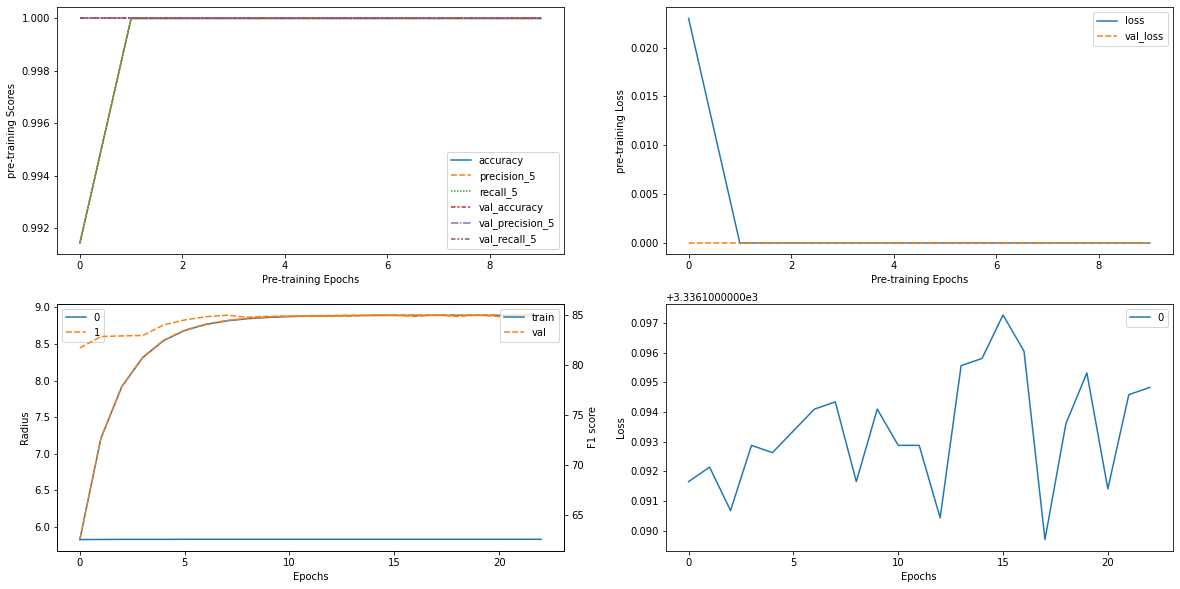

[[982   0   8]
 [  0 384 606]
 [  0   0 164]]
71.36
f1_weighted: 0.7446129907670689, f1_macro: 0.6343634996735683, f1_micro: 0.7136194029850748, f_measure: {'Known': 77.7448, 'Open': 34.8195, 'F1-score': 63.4363}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       990
           1       1.00      0.39      0.56       990
           5       0.21      1.00      0.35       164

    accuracy                           0.71      2144
   macro avg       0.74      0.79      0.63      2144
weighted avg       0.94      0.71      0.74      2144



In [7]:
comment="increase emsize a bit "
test_data, oset, hist = oset_train(ablation=10000,designated_ukc_cls=5,num_classes=2,embedding_size=18,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 8000
val_0:, 1000
test_0:, 1000
train_1:, 8000
val_1:, 1000
test_1:, 1000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
500/500 [==============================] - 48s 94ms/step - loss: 0.0152 - accuracy: 0.9942 - precision_6: 0.9942 - recall_6: 0.9942 - val_loss: 5.5603e-05 - val_accuracy: 1.0000 - val_precision_6: 1.0000 - val_recall_6: 1.0000
Epoch 2/10
500/500 [==============================] - 47s 93ms/step - loss: 1.0711e-05 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 5.5800e-05 - val_accuracy: 1.0000 - val_precision_6: 1.0000 - val_recall_6: 1.0000
Epoch 3/10
500/500 [==============================] - 46s 93ms/step - loss: 4.4919e-06 - accuracy: 1.0000 - precision_6: 1.0000 - recall_6: 1.0000 - val_loss: 3.3935e-05 - val_accuracy: 1.0000 - val_pr

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:05<00:00,  7.65it/s]


epoch: 1/200, train_loss: 4.433725357055664, F1_train: 0.626256006989952 F1_val: 0.8255213538735604


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:05<00:00,  7.64it/s]


epoch: 2/200, train_loss: 4.433725357055664, F1_train: 0.6267328894225521 F1_val: 0.8852312300397907


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:05<00:00,  7.65it/s]


epoch: 3/200, train_loss: 4.433728218078613, F1_train: 0.9249982031193847 F1_val: 0.9089531686604079


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:05<00:00,  7.63it/s]


epoch: 4/200, train_loss: 4.433721542358398, F1_train: 0.9251221615406725 F1_val: 0.9172737697483727


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.33it/s]


epoch: 5/200, train_loss: 4.433726787567139, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.28it/s]


epoch: 6/200, train_loss: 4.433732509613037, F1_train: 0.9252460665277678 F1_val: 0.9176018255686138


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.28it/s]


epoch: 7/200, train_loss: 4.433731555938721, F1_train: 0.9252873563218391 F1_val: 0.9185714026136754


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.34it/s]


epoch: 8/200, train_loss: 4.433732509613037, F1_train: 0.9253286401838949 F1_val: 0.9186113600046795


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.35it/s]


epoch: 9/200, train_loss: 4.433727264404297, F1_train: 0.9253699181152133 F1_val: 0.9173146014259753


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.41it/s]


epoch: 10/200, train_loss: 4.4337286949157715, F1_train: 0.9253699181152133 F1_val: 0.9179834079316121
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.38it/s]


epoch: 11/200, train_loss: 4.433729648590088, F1_train: 0.9253699181152133 F1_val: 0.9179566043315132
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.33it/s]


epoch: 12/200, train_loss: 4.433727264404297, F1_train: 0.9253699181152133 F1_val: 0.9176018255686138
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.36it/s]


epoch: 13/200, train_loss: 4.433725357055664, F1_train: 0.9253699181152133 F1_val: 0.9182840855959484
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.39it/s]


epoch: 14/200, train_loss: 4.433732032775879, F1_train: 0.9253699181152133 F1_val: 0.9179700217973028
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.34it/s]


epoch: 15/200, train_loss: 4.4337263107299805, F1_train: 0.9253699181152133 F1_val: 0.9185847530284907
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.21it/s]


epoch: 16/200, train_loss: 4.433730125427246, F1_train: 0.9253699181152133 F1_val: 0.9182840855959484
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.40it/s]


epoch: 17/200, train_loss: 4.433731555938721, F1_train: 0.9253699181152133 F1_val: 0.9179700217973028
train score not improving  going to wait state 8
val score not improving  going to wait state 8


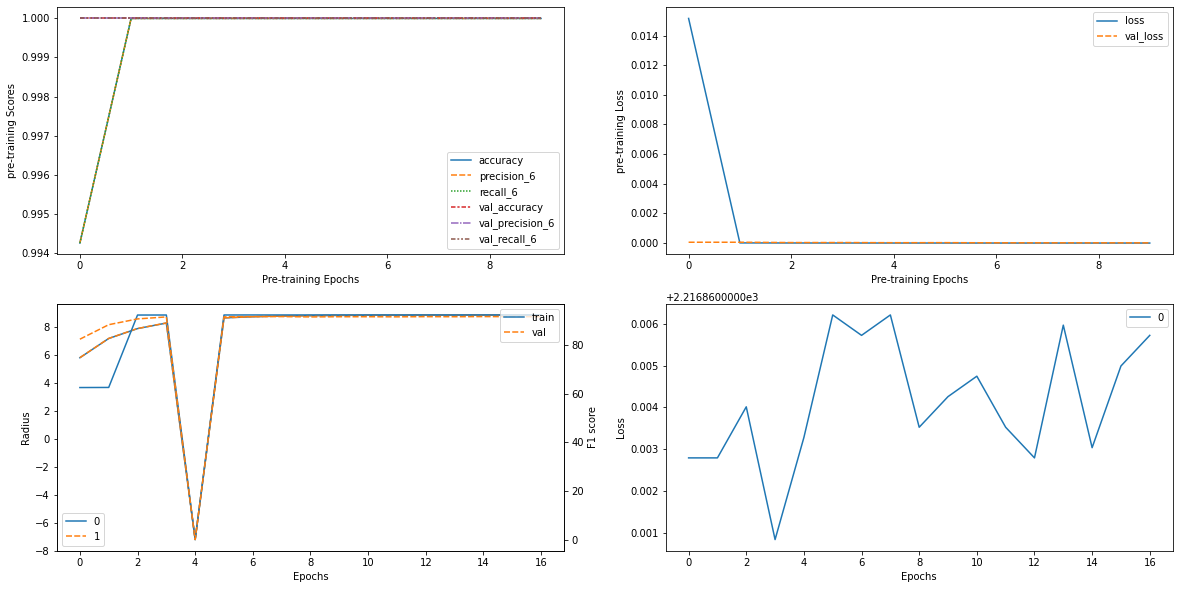

[[982   0   8]
 [  0 431 559]
 [  0   0 164]]
73.55
f1_weighted: 0.7680202776746371, f1_macro: 0.6563462372041863, f1_micro: 0.7355410447761194, f_measure: {'Known': 80.1279, 'Open': 36.648, 'F1-score': 65.6346}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       990
           1       1.00      0.44      0.61       990
           5       0.22      1.00      0.37       164

    accuracy                           0.74      2144
   macro avg       0.74      0.81      0.66      2144
weighted avg       0.94      0.74      0.77      2144



In [8]:
comment="increase emsize more"
test_data, oset, hist = oset_train(ablation=10000,designated_ukc_cls=5,num_classes=2,embedding_size=20,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 8000
val_0:, 1000
test_0:, 1000
train_1:, 8000
val_1:, 1000
test_1:, 1000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
500/500 [==============================] - 49s 96ms/step - loss: 0.0148 - accuracy: 0.9939 - precision_7: 0.9939 - recall_7: 0.9939 - val_loss: 2.0006e-05 - val_accuracy: 1.0000 - val_precision_7: 1.0000 - val_recall_7: 1.0000
Epoch 2/10
500/500 [==============================] - 48s 95ms/step - loss: 4.3043e-06 - accuracy: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - val_loss: 5.3803e-06 - val_accuracy: 1.0000 - val_precision_7: 1.0000 - val_recall_7: 1.0000
Epoch 3/10
500/500 [==============================] - 48s 96ms/step - loss: 1.5290e-06 - accuracy: 1.0000 - precision_7: 1.0000 - recall_7: 1.0000 - val_loss: 1.5360e-06 - val_accuracy: 1.0000 - val_pr

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.21it/s]


epoch: 1/200, train_loss: 3.8921468257904053, F1_train: 0.6275274594711471 F1_val: 0.9165475279695783


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.21it/s]


epoch: 2/200, train_loss: 3.8921420574188232, F1_train: 0.9257411528246358 F1_val: 0.9582335683839394


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.24it/s]


epoch: 3/200, train_loss: 3.8921406269073486, F1_train: 0.9260707367816917 F1_val: 0.9585222081664208


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:10<00:00,  7.10it/s]


epoch: 4/200, train_loss: 3.8921468257904053, F1_train: 0.9263176765865903 F1_val: 0.9585222081664208


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.23it/s]


epoch: 5/200, train_loss: 3.8921456336975098, F1_train: 0.9263999426399944 F1_val: 0.9585152838427947


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.20it/s]


epoch: 6/200, train_loss: 3.892141103744507, F1_train: 0.9263999426399944 F1_val: 0.9582230676838603
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.25it/s]


epoch: 7/200, train_loss: 3.8921382427215576, F1_train: 0.9264821851028748 F1_val: 0.9585048404762746


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.46it/s]


epoch: 8/200, train_loss: 3.8921403884887695, F1_train: 0.9265232974910395 F1_val: 0.9588106928532459


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.48it/s]


epoch: 9/200, train_loss: 3.892143487930298, F1_train: 0.9265232974910395 F1_val: 0.9582370534071595
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.33it/s]


epoch: 10/200, train_loss: 3.892144203186035, F1_train: 0.9265232974910395 F1_val: 0.9585291023842918
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.50it/s]


epoch: 11/200, train_loss: 3.8921451568603516, F1_train: 0.9265232974910395 F1_val: 0.9582265755471566
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.32it/s]


epoch: 12/200, train_loss: 3.892144203186035, F1_train: 0.9265644039853773 F1_val: 0.9585187497801386


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:10<00:00,  7.08it/s]


epoch: 13/200, train_loss: 3.892143964767456, F1_train: 0.9265644039853773 F1_val: 0.9585187497801386
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.23it/s]


epoch: 14/200, train_loss: 3.892141819000244, F1_train: 0.9265644039853773 F1_val: 0.9585256590262908
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.24it/s]


epoch: 15/200, train_loss: 3.8921470642089844, F1_train: 0.9265644039853773 F1_val: 0.9588038369283408
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.24it/s]


epoch: 16/200, train_loss: 3.8921477794647217, F1_train: 0.9265644039853773 F1_val: 0.958814109607102


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.25it/s]


epoch: 17/200, train_loss: 3.8921444416046143, F1_train: 0.9265644039853773 F1_val: 0.9588209208195198


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.25it/s]


epoch: 18/200, train_loss: 3.892137289047241, F1_train: 0.9265644039853773 F1_val: 0.9585083292157832
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:09<00:00,  7.21it/s]


epoch: 19/200, train_loss: 3.8921430110931396, F1_train: 0.9265644039853773 F1_val: 0.9582300757722092
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.48it/s]


epoch: 20/200, train_loss: 3.892148494720459, F1_train: 0.9265644039853773 F1_val: 0.9587934966290942
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.49it/s]


epoch: 21/200, train_loss: 3.8921470642089844, F1_train: 0.9265644039853773 F1_val: 0.9585187497801386
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.35it/s]


epoch: 22/200, train_loss: 3.8921477794647217, F1_train: 0.9265644039853773 F1_val: 0.958814109607102
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.51it/s]


epoch: 23/200, train_loss: 3.8921453952789307, F1_train: 0.9265644039853773 F1_val: 0.9582124980136659
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.51it/s]


epoch: 24/200, train_loss: 3.8921384811401367, F1_train: 0.9265644039853773 F1_val: 0.9588038369283408
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:06<00:00,  7.51it/s]


epoch: 25/200, train_loss: 3.892143726348877, F1_train: 0.9265644039853773 F1_val: 0.9588038369283408
train score not improving  going to wait state 8
val score not improving  going to wait state 8


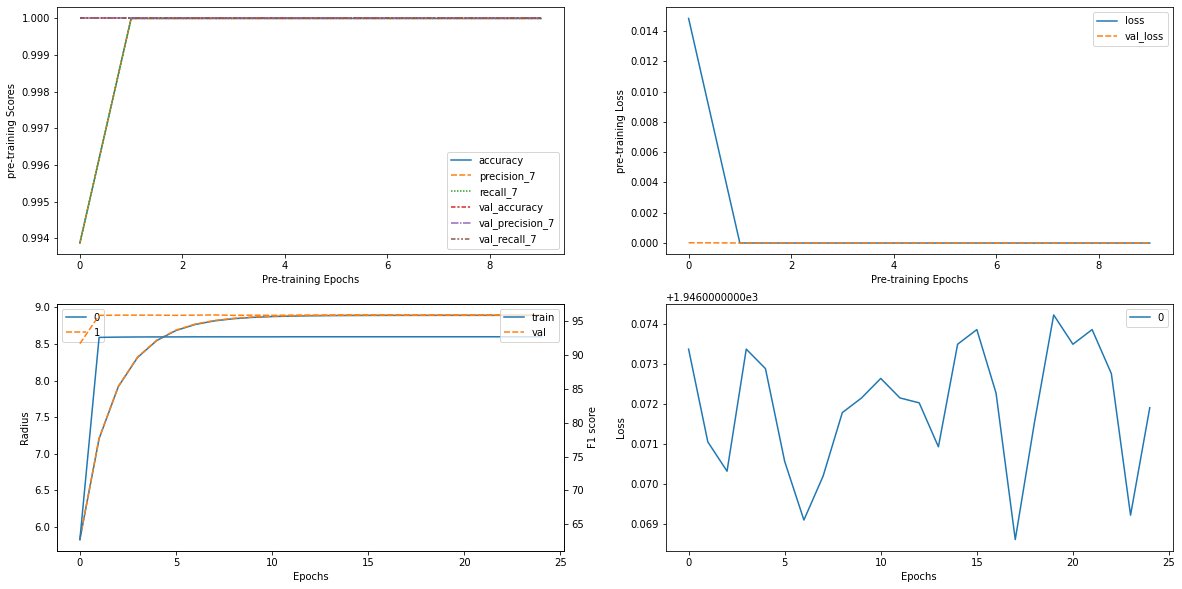

[[982   0   8]
 [  0 431 559]
 [  1   0 163]]
73.51
f1_weighted: 0.7676474233559667, f1_macro: 0.6555689074389014, f1_micro: 0.7350746268656715, f_measure: {'Known': 80.1027, 'Open': 36.4653, 'F1-score': 65.5569}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       990
           1       1.00      0.44      0.61       990
           5       0.22      0.99      0.36       164

    accuracy                           0.74      2144
   macro avg       0.74      0.81      0.66      2144
weighted avg       0.94      0.74      0.77      2144



In [9]:
comment="increase emsize more"
test_data, oset, hist = oset_train(ablation=10000,designated_ukc_cls=5,num_classes=2,embedding_size=22,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 8000
val_0:, 1000
test_0:, 1000
train_1:, 8000
val_1:, 1000
test_1:, 1000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/15
500/500 [==============================] - 46s 91ms/step - loss: 0.0148 - accuracy: 0.9939 - precision_8: 0.9939 - recall_8: 0.9939 - val_loss: 2.0006e-05 - val_accuracy: 1.0000 - val_precision_8: 1.0000 - val_recall_8: 1.0000
Epoch 2/15
500/500 [==============================] - 45s 89ms/step - loss: 4.3043e-06 - accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - val_loss: 5.3803e-06 - val_accuracy: 1.0000 - val_precision_8: 1.0000 - val_recall_8: 1.0000
Epoch 3/15
500/500 [==============================] - 45s 90ms/step - loss: 1.5290e-06 - accuracy: 1.0000 - precision_8: 1.0000 - recall_8: 1.0000 - val_loss: 1.5360e-06 - val_accuracy: 1.0000 - val_pr

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.42it/s]


epoch: 1/200, train_loss: 4.146574974060059, F1_train: 0.6273683990066133 F1_val: 0.8964986516324812


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.43it/s]


epoch: 2/200, train_loss: 4.146572113037109, F1_train: 0.9252460665277678 F1_val: 0.9582230676838603


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.42it/s]


epoch: 3/200, train_loss: 4.146579265594482, F1_train: 0.925947187141217 F1_val: 0.9582230676838603


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.42it/s]


epoch: 4/200, train_loss: 4.1465744972229, F1_train: 0.926029559477687 F1_val: 0.9585256590262908


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.44it/s]


epoch: 5/200, train_loss: 4.146578788757324, F1_train: 0.9261530736675991 F1_val: 0.9588038369283408


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.40it/s]


epoch: 6/200, train_loss: 4.146579742431641, F1_train: 0.9262765347102697 F1_val: 0.958814109607102


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.26it/s]


epoch: 7/200, train_loss: 4.146572113037109, F1_train: 0.9263176765865903 F1_val: 0.9588209208195198


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.42it/s]


epoch: 8/200, train_loss: 4.146573066711426, F1_train: 0.9263588125627421 F1_val: 0.9585083292157832


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.42it/s]


epoch: 9/200, train_loss: 4.146575450897217, F1_train: 0.9263588125627421 F1_val: 0.9582300757722092
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.38it/s]


epoch: 10/200, train_loss: 4.1465744972229, F1_train: 0.9263588125627421 F1_val: 0.9587934966290942
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.43it/s]


epoch: 11/200, train_loss: 4.146571159362793, F1_train: 0.9263999426399944 F1_val: 0.9585187497801386


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.41it/s]


epoch: 12/200, train_loss: 4.146578311920166, F1_train: 0.9263999426399944 F1_val: 0.958814109607102
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.38it/s]


epoch: 13/200, train_loss: 4.146574020385742, F1_train: 0.9263999426399944 F1_val: 0.9582124980136659
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.42it/s]


epoch: 14/200, train_loss: 4.1465744972229, F1_train: 0.9263999426399944 F1_val: 0.9588038369283408
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.42it/s]


epoch: 15/200, train_loss: 4.146574020385742, F1_train: 0.9263999426399944 F1_val: 0.9588038369283408
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.40it/s]


epoch: 16/200, train_loss: 4.146575450897217, F1_train: 0.9263999426399944 F1_val: 0.9588175189211021
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:08<00:00,  7.33it/s]


epoch: 17/200, train_loss: 4.14657735824585, F1_train: 0.9263999426399944 F1_val: 0.9585222081664208
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.41it/s]


epoch: 18/200, train_loss: 4.146573543548584, F1_train: 0.9263999426399944 F1_val: 0.9585118103296316
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [01:07<00:00,  7.41it/s]


epoch: 19/200, train_loss: 4.146576404571533, F1_train: 0.9263999426399944 F1_val: 0.9582335683839394
train score not improving  going to wait state 8
val score not improving  going to wait state 8


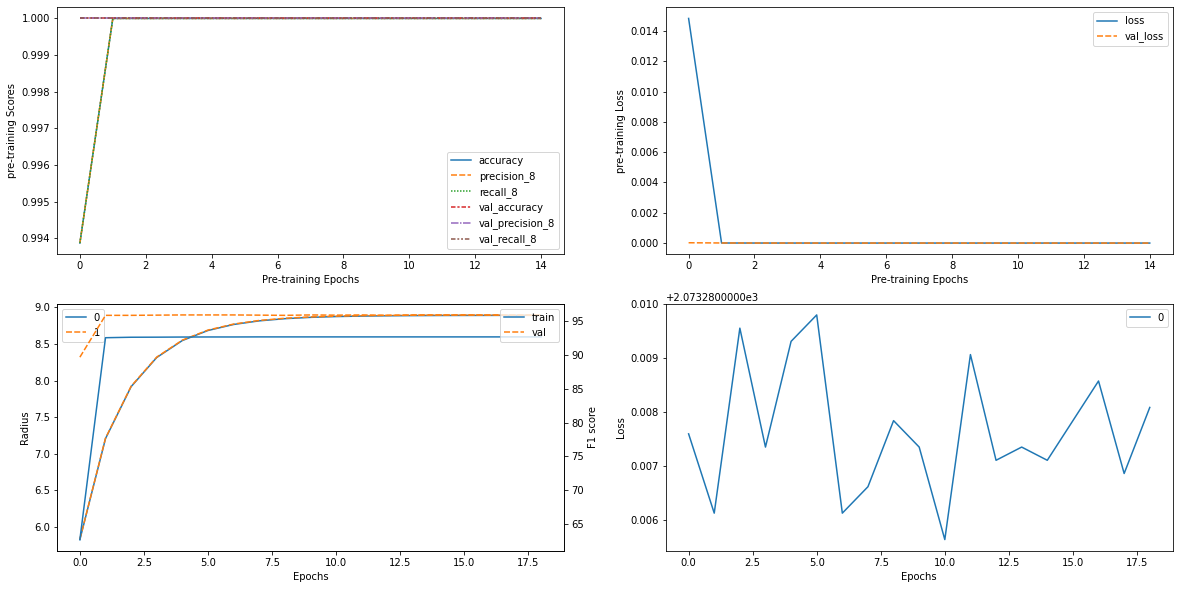

[[982   0   8]
 [  0 431 559]
 [  0   0 164]]
73.55
f1_weighted: 0.7680202776746371, f1_macro: 0.6563462372041863, f1_micro: 0.7355410447761194, f_measure: {'Known': 80.1279, 'Open': 36.648, 'F1-score': 65.6346}
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       990
           1       1.00      0.44      0.61       990
           5       0.22      1.00      0.37       164

    accuracy                           0.74      2144
   macro avg       0.74      0.81      0.66      2144
weighted avg       0.94      0.74      0.77      2144



In [10]:
comment="increase pretraining"
test_data, oset, hist = oset_train(ablation=10000,designated_ukc_cls=5,num_classes=2,embedding_size=22,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=15, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 16000
val_0:, 2000
test_0:, 2000
train_1:, 16000
val_1:, 2000
test_1:, 2000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/15
1000/1000 [==============================] - 92s 92ms/step - loss: 0.0128 - accuracy: 0.9964 - precision_9: 0.9964 - recall_9: 0.9964 - val_loss: 0.1325 - val_accuracy: 0.9557 - val_precision_9: 0.9557 - val_recall_9: 0.9557
Epoch 2/15
1000/1000 [==============================] - 98s 98ms/step - loss: 2.1739e-05 - accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9973 - val_precision_9: 0.9973 - val_recall_9: 0.9973
Epoch 3/15
1000/1000 [==============================] - 97s 97ms/step - loss: 6.4591e-07 - accuracy: 1.0000 - precision_9: 1.0000 - recall_9: 1.0000 - val_loss: 0.0157 - val_accuracy: 0.9958 - val_precis

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:02<00:00,  5.47it/s]


epoch: 1/200, train_loss: 2.6824378967285156, F1_train: 0.9735125838074536 F1_val: 0.8657754875511808


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:01<00:00,  5.51it/s]


epoch: 2/200, train_loss: 2.682438373565674, F1_train: 0.9869575921016669 F1_val: 0.8682975457121902


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:03<00:00,  5.45it/s]


epoch: 3/200, train_loss: 2.6824417114257812, F1_train: 0.9869892224927034 F1_val: 0.8684338499743651


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:02<00:00,  5.48it/s]


epoch: 4/200, train_loss: 2.6824376583099365, F1_train: 0.9870050361966441 F1_val: 0.8685700831150884


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:06<00:00,  5.37it/s]


epoch: 5/200, train_loss: 2.682438850402832, F1_train: 0.9870050361966441 F1_val: 0.8685700831150884
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:03<00:00,  5.44it/s]


epoch: 6/200, train_loss: 2.6824395656585693, F1_train: 0.9870050361966441 F1_val: 0.8687062451900108


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.57it/s]


epoch: 7/200, train_loss: 2.6824395656585693, F1_train: 0.9870050361966441 F1_val: 0.8687062451900108
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.54it/s]


epoch: 8/200, train_loss: 2.6824424266815186, F1_train: 0.9870050361966441 F1_val: 0.8687062451900108
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:39<00:00,  6.27it/s]


epoch: 9/200, train_loss: 2.6824398040771484, F1_train: 0.9870050361966441 F1_val: 0.8687062451900108
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:42<00:00,  6.17it/s]


epoch: 10/200, train_loss: 2.682438850402832, F1_train: 0.9870050361966441 F1_val: 0.8687062451900108
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.86it/s]


epoch: 11/200, train_loss: 2.682438611984253, F1_train: 0.9870050361966441 F1_val: 0.8687062451900108
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:28<00:00,  6.74it/s]


epoch: 12/200, train_loss: 2.6824376583099365, F1_train: 0.9870050361966441 F1_val: 0.8687062451900108
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:24<00:00,  6.91it/s]


epoch: 13/200, train_loss: 2.6824417114257812, F1_train: 0.9870050361966441 F1_val: 0.8687062451900108
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.87it/s]


epoch: 14/200, train_loss: 2.6824393272399902, F1_train: 0.9870050361966441 F1_val: 0.8687062451900108
train score not improving  going to wait state 8
val score not improving  going to wait state 8


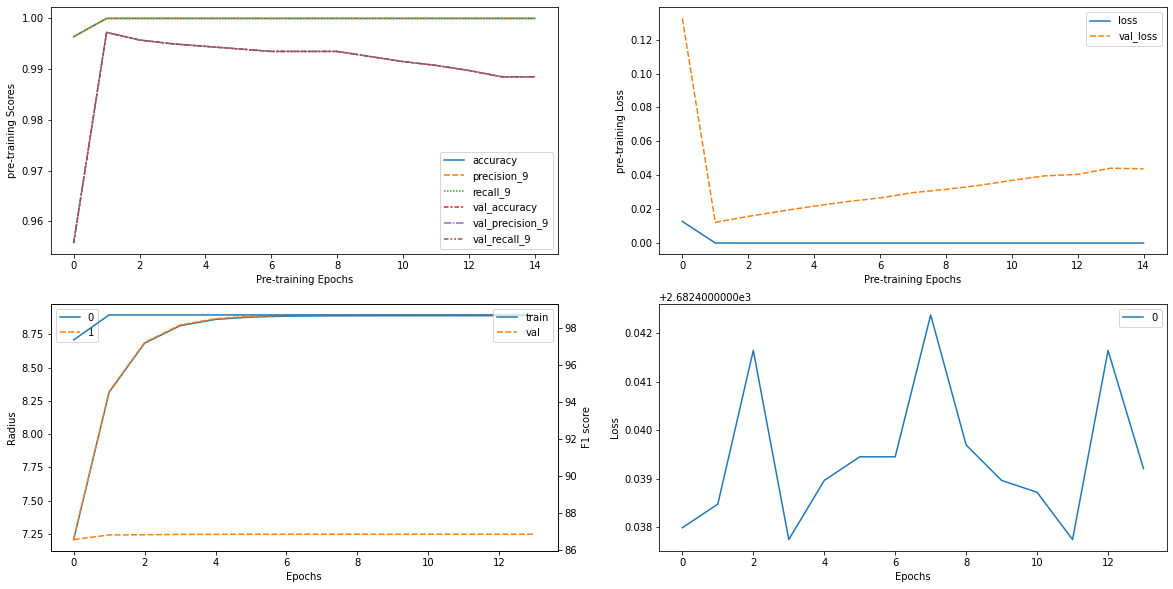

[[1997    0    0]
 [   0  405 1593]
 [   0    0  165]]
61.71
f1_weighted: 0.6487495862194039, f1_macro: 0.5028951719866547, f1_micro: 0.6170673076923077, f_measure: {'Known': 66.8539, 'Open': 17.1607, 'F1-score': 50.2895}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       1.00      0.20      0.34      1998
           5       0.09      1.00      0.17       165

    accuracy                           0.62      4160
   macro avg       0.70      0.73      0.50      4160
weighted avg       0.96      0.62      0.65      4160



In [11]:
comment="increase data more"
test_data, oset, hist = oset_train(ablation=20000,designated_ukc_cls=5,num_classes=2,embedding_size=22,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=15, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 16000
val_0:, 2000
test_0:, 2000
train_1:, 16000
val_1:, 2000
test_1:, 2000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/15
1000/1000 [==============================] - 105s 105ms/step - loss: 0.0079 - accuracy: 0.9971 - precision_10: 0.9971 - recall_10: 0.9971 - val_loss: 0.1113 - val_accuracy: 0.9670 - val_precision_10: 0.9670 - val_recall_10: 0.9670
Epoch 2/15
1000/1000 [==============================] - 108s 108ms/step - loss: 2.2349e-06 - accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - val_loss: 0.1063 - val_accuracy: 0.9697 - val_precision_10: 0.9697 - val_recall_10: 0.9697
Epoch 3/15
1000/1000 [==============================] - 102s 102ms/step - loss: 7.5533e-07 - accuracy: 1.0000 - precision_10: 1.0000 - recall_10: 1.0000 - val_loss: 0.1007 - val_accuracy: 0.9

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.88it/s]


epoch: 1/200, train_loss: 2.1597723960876465, F1_train: 0.9886381795519191 F1_val: 0.8768220717406319


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:26<00:00,  6.82it/s]


epoch: 2/200, train_loss: 2.1597602367401123, F1_train: 0.9908674346082861 F1_val: 0.9053964845214837


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.88it/s]


epoch: 3/200, train_loss: 2.159773349761963, F1_train: 0.9916761977379591 F1_val: 0.9065565327053616


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:46<00:00,  6.01it/s]


epoch: 4/200, train_loss: 2.159776449203491, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:36<00:00,  6.40it/s]


epoch: 5/200, train_loss: 2.1597681045532227, F1_train: 0.9949016636676453 F1_val: 0.9065565327053616


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:30<00:00,  6.63it/s]


epoch: 6/200, train_loss: 2.159773826599121, F1_train: 0.9952203678581569 F1_val: 0.9065565327053616


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.87it/s]


epoch: 7/200, train_loss: 2.159773349761963, F1_train: 0.9953318193287913 F1_val: 0.9065565327053616


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:22<00:00,  7.01it/s]


epoch: 8/200, train_loss: 2.1597676277160645, F1_train: 0.9954113973950613 F1_val: 0.9065565327053616


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:21<00:00,  7.08it/s]


epoch: 9/200, train_loss: 2.1597750186920166, F1_train: 0.9954113973950613 F1_val: 0.9065565327053616
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:22<00:00,  7.04it/s]


epoch: 10/200, train_loss: 2.159775495529175, F1_train: 0.4909339694271103 F1_val: 0.48905168466697196
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:20<00:00,  7.13it/s]


epoch: 11/200, train_loss: 2.1597704887390137, F1_train: 0.9954273099968464 F1_val: 0.9065565327053616


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.99it/s]


epoch: 12/200, train_loss: 2.1597723960876465, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.98it/s]


epoch: 13/200, train_loss: 2.159776449203491, F1_train: 0.9954273099968464 F1_val: 0.9065565327053616
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.95it/s]


epoch: 14/200, train_loss: 2.1597790718078613, F1_train: 0.9954273099968464 F1_val: 0.9065565327053616
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.97it/s]


epoch: 15/200, train_loss: 2.159776210784912, F1_train: 0.9954273099968464 F1_val: 0.9065565327053616
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.89it/s]


epoch: 16/200, train_loss: 2.1597728729248047, F1_train: 0.9954273099968464 F1_val: 0.9065565327053616
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.88it/s]


epoch: 17/200, train_loss: 2.1597726345062256, F1_train: 0.9954273099968464 F1_val: 0.9065565327053616
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:24<00:00,  6.93it/s]


epoch: 18/200, train_loss: 2.1597743034362793, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:19<00:00,  7.19it/s]


epoch: 19/200, train_loss: 2.159773111343384, F1_train: 0.9954273099968464 F1_val: 0.9065565327053616
train score not improving  going to wait state 8
val score not improving  going to wait state 8


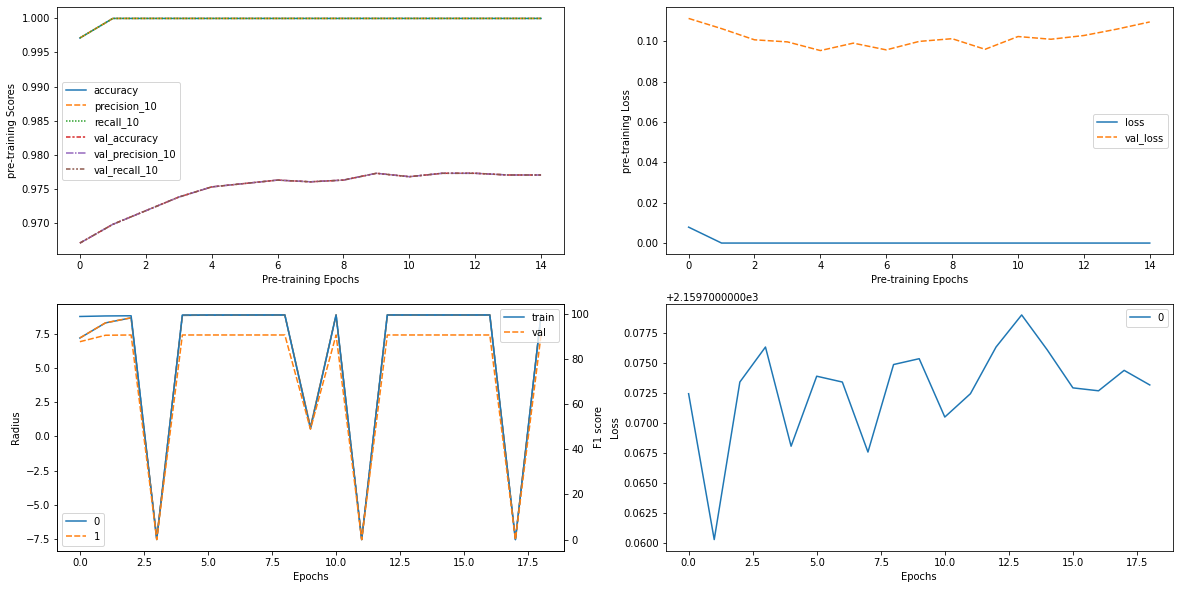

[[1997    0    0]
 [   6  543 1449]
 [   0   11  154]]
64.76
f1_weighted: 0.6906237801432944, f1_macro: 0.532752244712691, f1_micro: 0.6475961538461539, f_measure: {'Known': 71.2024, 'Open': 17.4208, 'F1-score': 53.2752}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       0.98      0.27      0.43      1998
           5       0.10      0.93      0.17       165

    accuracy                           0.65      4160
   macro avg       0.69      0.74      0.53      4160
weighted avg       0.95      0.65      0.69      4160



In [12]:
comment="increase emsize a bit with 20K"
test_data, oset, hist = oset_train(ablation=20000,designated_ukc_cls=5,num_classes=2,embedding_size=24,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=15, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 16000
val_0:, 2000
test_0:, 2000
train_1:, 16000
val_1:, 2000
test_1:, 2000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/15
1000/1000 [==============================] - 97s 96ms/step - loss: 0.0092 - accuracy: 0.9968 - precision_11: 0.9968 - recall_11: 0.9968 - val_loss: 0.3313 - val_accuracy: 0.9337 - val_precision_11: 0.9337 - val_recall_11: 0.9337
Epoch 2/15
1000/1000 [==============================] - 94s 94ms/step - loss: 5.7963e-04 - accuracy: 0.9999 - precision_11: 0.9999 - recall_11: 0.9999 - val_loss: 0.1212 - val_accuracy: 0.9650 - val_precision_11: 0.9650 - val_recall_11: 0.9650
Epoch 3/15
1000/1000 [==============================] - 95s 95ms/step - loss: 3.4955e-07 - accuracy: 1.0000 - precision_11: 1.0000 - recall_11: 1.0000 - val_loss: 0.1331 - val_accuracy: 0.9647 - 

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.55it/s]


epoch: 1/200, train_loss: 4.147435665130615, F1_train: 0.8103824760051868 F1_val: 0.8386243386243386


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.53it/s]


epoch: 2/200, train_loss: 4.147428512573242, F1_train: 0.8499213996610149 F1_val: 0.8682880606443462


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.55it/s]


epoch: 3/200, train_loss: 4.147435665130615, F1_train: 0.8537025148356523 F1_val: 0.869284137496058


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.48it/s]


epoch: 4/200, train_loss: 4.147443771362305, F1_train: 0.8541981297587168 F1_val: 0.869284137496058


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.55it/s]


epoch: 5/200, train_loss: 4.14743185043335, F1_train: 0.8546409307977519 F1_val: 0.8694829760403532


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.52it/s]


epoch: 6/200, train_loss: 4.14743709564209, F1_train: 0.8546669590079525 F1_val: 0.8696816892530728


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:13<00:00,  7.50it/s]


epoch: 7/200, train_loss: 4.147432327270508, F1_train: 0.8546669590079525 F1_val: 0.8696816892530728
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.53it/s]


epoch: 8/200, train_loss: 4.147434711456299, F1_train: 0.8546669590079525 F1_val: 0.8696816892530728
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.52it/s]


epoch: 9/200, train_loss: 4.147439956665039, F1_train: 0.8546669590079525 F1_val: 0.8696816892530728
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.52it/s]


epoch: 10/200, train_loss: 4.147436618804932, F1_train: 0.8546669590079525 F1_val: 0.8696816892530728
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.54it/s]


epoch: 11/200, train_loss: 4.147435188293457, F1_train: 0.8546669590079525 F1_val: 0.8696816892530728
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.53it/s]


epoch: 12/200, train_loss: 4.147437572479248, F1_train: 0.8546669590079525 F1_val: 0.8696816892530728
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:12<00:00,  7.53it/s]


epoch: 13/200, train_loss: 4.1474385261535645, F1_train: 0.8546669590079525 F1_val: 0.8696816892530728
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.45it/s]


epoch: 14/200, train_loss: 4.147435665130615, F1_train: 0.8546669590079525 F1_val: 0.8696816892530728
train score not improving  going to wait state 8
val score not improving  going to wait state 8


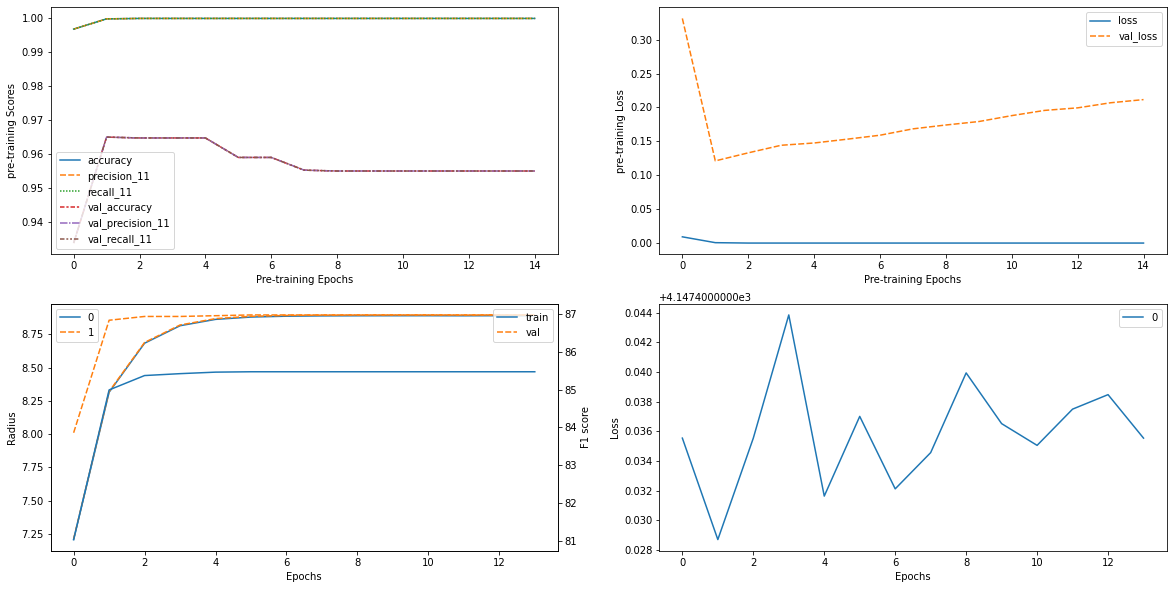

[[1997    0    0]
 [   0  170 1828]
 [   0    0  165]]
56.06
f1_weighted: 0.5614353796657844, f1_macro: 0.43658197935084075, f1_micro: 0.5605769230769231, f_measure: {'Known': 57.8413, 'Open': 15.2919, 'F1-score': 43.6582}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       1.00      0.09      0.16      1998
           5       0.08      1.00      0.15       165

    accuracy                           0.56      4160
   macro avg       0.69      0.70      0.44      4160
weighted avg       0.96      0.56      0.56      4160



In [13]:
comment="increase emsize more with 20K"
test_data, oset, hist = oset_train(ablation=20000,designated_ukc_cls=5,num_classes=2,embedding_size=28,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=15, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 16000
val_0:, 2000
test_0:, 2000
train_1:, 16000
val_1:, 2000
test_1:, 2000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/20
1000/1000 [==============================] - 93s 92ms/step - loss: 0.0092 - accuracy: 0.9968 - precision_12: 0.9968 - recall_12: 0.9968 - val_loss: 0.3313 - val_accuracy: 0.9337 - val_precision_12: 0.9337 - val_recall_12: 0.9337
Epoch 2/20
1000/1000 [==============================] - 93s 93ms/step - loss: 5.7963e-04 - accuracy: 0.9999 - precision_12: 0.9999 - recall_12: 0.9999 - val_loss: 0.1212 - val_accuracy: 0.9650 - val_precision_12: 0.9650 - val_recall_12: 0.9650
Epoch 3/20
1000/1000 [==============================] - 93s 93ms/step - loss: 3.4955e-07 - accuracy: 1.0000 - precision_12: 1.0000 - recall_12: 1.0000 - val_loss: 0.1331 - val_accuracy: 0.9647 - 

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.96it/s]


epoch: 1/200, train_loss: 4.350978851318359, F1_train: 0.7485601678406079 F1_val: 0.8377483443708609


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


epoch: 2/200, train_loss: 4.3509745597839355, F1_train: 0.8166908999643854 F1_val: 0.8674889310562935


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.44it/s]


epoch: 3/200, train_loss: 4.350985050201416, F1_train: 0.8506600776081688 F1_val: 0.8680884676145341


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.43it/s]


epoch: 4/200, train_loss: 4.350980281829834, F1_train: 0.8519224846012171 F1_val: 0.8684875276286707


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.38it/s]


epoch: 5/200, train_loss: 4.350977420806885, F1_train: 0.852289762521257 F1_val: 0.8688860839381509


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.43it/s]


epoch: 6/200, train_loss: 4.350982189178467, F1_train: 0.8523421968148809 F1_val: 0.8688860839381509


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.40it/s]


epoch: 7/200, train_loss: 4.35098123550415, F1_train: 0.8523684107781974 F1_val: 0.8688860839381509


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


epoch: 8/200, train_loss: 4.3509907722473145, F1_train: 0.8523684107781974 F1_val: 0.8688860839381509
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:16<00:00,  7.35it/s]


epoch: 9/200, train_loss: 4.350979328155518, F1_train: 0.8523684107781974 F1_val: 0.8688860839381509
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:15<00:00,  7.39it/s]


epoch: 10/200, train_loss: 4.35098123550415, F1_train: 0.8523684107781974 F1_val: 0.8688860839381509
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


epoch: 11/200, train_loss: 4.350983142852783, F1_train: 0.8523684107781974 F1_val: 0.8688860839381509
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


epoch: 12/200, train_loss: 4.350983619689941, F1_train: 0.8523684107781974 F1_val: 0.8688860839381509
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.42it/s]


epoch: 13/200, train_loss: 4.350984573364258, F1_train: 0.8523684107781974 F1_val: 0.8688860839381509
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:14<00:00,  7.41it/s]


epoch: 14/200, train_loss: 4.350978374481201, F1_train: 0.8523684107781974 F1_val: 0.8688860839381509
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:16<00:00,  7.35it/s]


epoch: 15/200, train_loss: 4.350978851318359, F1_train: 0.8523684107781974 F1_val: 0.8688860839381509
train score not improving  going to wait state 8
val score not improving  going to wait state 8


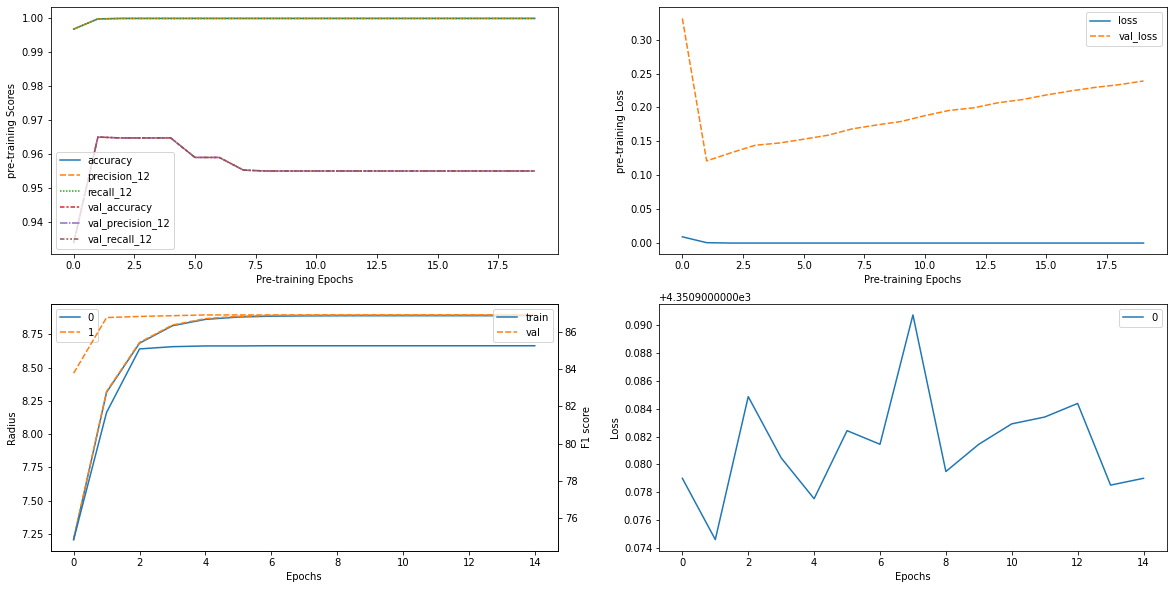

[[1997    0    0]
 [   0  161 1837]
 [   0    0  165]]
55.84
f1_weighted: 0.5577199184954277, f1_macro: 0.4338091285916821, f1_micro: 0.5584134615384615, f_measure: {'Known': 57.4572, 'Open': 15.2284, 'F1-score': 43.3809}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       1.00      0.08      0.15      1998
           5       0.08      1.00      0.15       165

    accuracy                           0.56      4160
   macro avg       0.69      0.69      0.43      4160
weighted avg       0.96      0.56      0.56      4160



In [14]:
comment="increase pretrain with 20K"
test_data, oset, hist = oset_train(ablation=20000,designated_ukc_cls=5,num_classes=2,embedding_size=28,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=20, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 16000
val_0:, 2000
test_0:, 2000
train_1:, 16000
val_1:, 2000
test_1:, 2000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
1000/1000 [==============================] - 89s 89ms/step - loss: 0.0092 - accuracy: 0.9968 - precision_13: 0.9968 - recall_13: 0.9968 - val_loss: 0.3313 - val_accuracy: 0.9337 - val_precision_13: 0.9337 - val_recall_13: 0.9337
Epoch 2/10
1000/1000 [==============================] - 93s 93ms/step - loss: 5.7963e-04 - accuracy: 0.9999 - precision_13: 0.9999 - recall_13: 0.9999 - val_loss: 0.1212 - val_accuracy: 0.9650 - val_precision_13: 0.9650 - val_recall_13: 0.9650
Epoch 3/10
1000/1000 [==============================] - 97s 97ms/step - loss: 3.4955e-07 - accuracy: 1.0000 - precision_13: 1.0000 - recall_13: 1.0000 - val_loss: 0.1331 - val_accuracy: 0.9647 - 

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:20<00:00,  7.11it/s]


epoch: 1/200, train_loss: 3.98655366897583, F1_train: 0.812869210921132 F1_val: 0.8656834760545512


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:21<00:00,  7.06it/s]


epoch: 2/200, train_loss: 3.9865522384643555, F1_train: 0.8534936072079741 F1_val: 0.8690851735015773


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.88it/s]


epoch: 3/200, train_loss: 3.986549139022827, F1_train: 0.8551091175692183 F1_val: 0.8702770780856421


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:24<00:00,  6.92it/s]


epoch: 4/200, train_loss: 3.98654842376709, F1_train: 0.8558101253773125 F1_val: 0.8710691823899371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:21<00:00,  7.06it/s]


epoch: 5/200, train_loss: 3.986544609069824, F1_train: 0.8559656979700837 F1_val: 0.8710691823899371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.96it/s]


epoch: 6/200, train_loss: 3.986551523208618, F1_train: 0.8559916194301982 F1_val: 0.8710691823899371


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.95it/s]


epoch: 7/200, train_loss: 3.9865474700927734, F1_train: 0.8559916194301982 F1_val: 0.8710691823899371
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:22<00:00,  6.99it/s]


epoch: 8/200, train_loss: 3.986553430557251, F1_train: 0.8559916194301982 F1_val: 0.8710691823899371
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:26<00:00,  6.84it/s]


epoch: 9/200, train_loss: 3.98654842376709, F1_train: 0.8559916194301982 F1_val: 0.8710691823899371
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:23<00:00,  6.98it/s]


epoch: 10/200, train_loss: 3.9865496158599854, F1_train: 0.8559916194301982 F1_val: 0.8710691823899371
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:22<00:00,  7.02it/s]


epoch: 11/200, train_loss: 3.98655366897583, F1_train: 0.8559916194301982 F1_val: 0.8710691823899371
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:24<00:00,  6.92it/s]


epoch: 12/200, train_loss: 3.9865520000457764, F1_train: 0.8559916194301982 F1_val: 0.8710691823899371
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:26<00:00,  6.83it/s]


epoch: 13/200, train_loss: 3.986562967300415, F1_train: 0.8559916194301982 F1_val: 0.8710691823899371
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.80it/s]


epoch: 14/200, train_loss: 3.9865527153015137, F1_train: 0.8559916194301982 F1_val: 0.8710691823899371
train score not improving  going to wait state 8
val score not improving  going to wait state 8


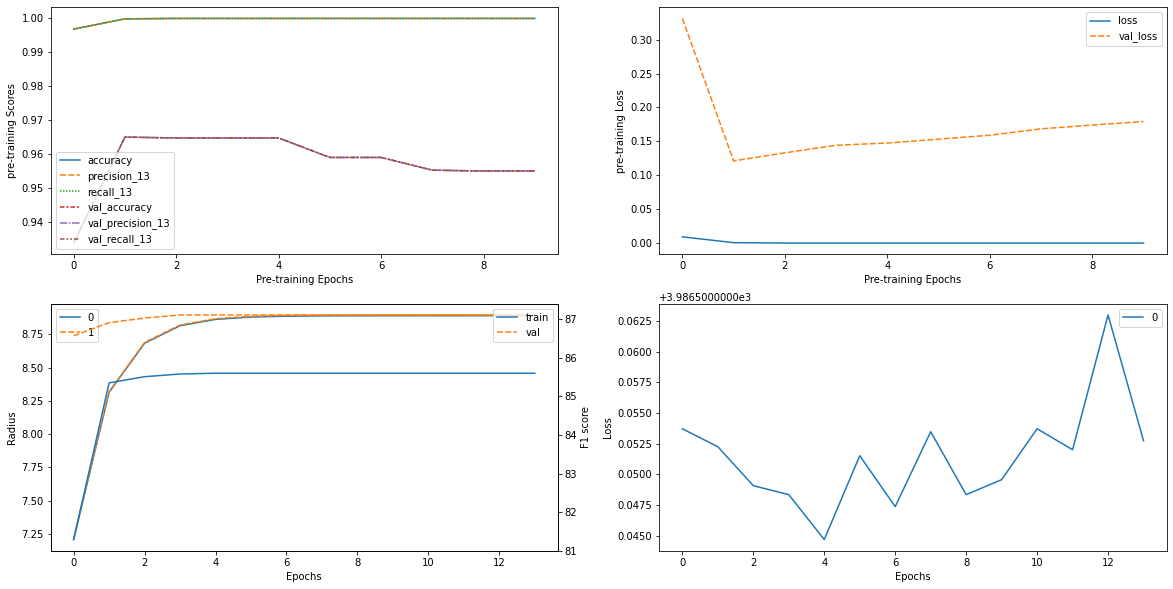

[[1997    0    0]
 [   0  180 1818]
 [   0    0  165]]
56.3
f1_weighted: 0.5655281480517959, f1_macro: 0.43964018037151603, f1_micro: 0.5629807692307692, f_measure: {'Known': 58.2645, 'Open': 15.3631, 'F1-score': 43.964}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       1.00      0.09      0.17      1998
           5       0.08      1.00      0.15       165

    accuracy                           0.56      4160
   macro avg       0.69      0.70      0.44      4160
weighted avg       0.96      0.56      0.57      4160



In [15]:
comment="decrease pretrain with 20K"
test_data, oset, hist = oset_train(ablation=20000,designated_ukc_cls=5,num_classes=2,embedding_size=28,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)

padded_num_seq_df loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgl_ukc.pkl
trained tokenizer, tk, loaded from C:\Users\Bhujay_ROG\MyDev\OCLog\oclog\BGL\data\bgltkukc.pkl
train_0:, 16000
val_0:, 2000
test_0:, 2000
train_1:, 16000
val_1:, 2000
test_1:, 2000
class 5 is added as ukc
ukc_5:, 165
vocab_size: 50
Epoch 1/10
1000/1000 [==============================] - 103s 102ms/step - loss: 0.0060 - accuracy: 0.9983 - precision_15: 0.9983 - recall_15: 0.9983 - val_loss: 0.1151 - val_accuracy: 0.9715 - val_precision_15: 0.9715 - val_recall_15: 0.9715
Epoch 2/10
1000/1000 [==============================] - 107s 107ms/step - loss: 4.6426e-06 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000 - val_loss: 0.0958 - val_accuracy: 0.9760 - val_precision_15: 0.9760 - val_recall_15: 0.9760
Epoch 3/10
1000/1000 [==============================] - 105s 105ms/step - loss: 7.6768e-07 - accuracy: 1.0000 - precision_15: 1.0000 - recall_15: 1.0000 - val_loss: 0.0967 - val_accuracy: 0.9

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.78it/s]


epoch: 1/200, train_loss: 1.8503683805465698, F1_train: 0.9901698371729917 F1_val: 0.8715570144141572


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:26<00:00,  6.84it/s]


epoch: 2/200, train_loss: 1.8503681421279907, F1_train: 0.9906729483669701 F1_val: 0.8999801158074539


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:25<00:00,  6.87it/s]


epoch: 3/200, train_loss: 1.8503717184066772, F1_train: 0.9907702100572883 F1_val: 0.9023073075028882


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:27<00:00,  6.79it/s]


epoch: 4/200, train_loss: 1.8503663539886475, F1_train: 0.9908026223664949 F1_val: 0.9028417882833157


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:22<00:00,  7.01it/s]


epoch: 5/200, train_loss: 1.8503625392913818, F1_train: 0.9908350305498982 F1_val: 0.9031975776161822


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:24<00:00,  6.94it/s]


epoch: 6/200, train_loss: 1.8503704071044922, F1_train: 0.9908512330946698 F1_val: 0.9033753132113789


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:26<00:00,  6.82it/s]


epoch: 7/200, train_loss: 1.8503704071044922, F1_train: 0.9908512330946698 F1_val: 0.9033753132113789
train score not improving  going to wait state 1
val score not improving  going to wait state 1


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:22<00:00,  7.00it/s]


epoch: 8/200, train_loss: 1.850374698638916, F1_train: 0.9908512330946698 F1_val: 0.9033753132113789
train score not improving  going to wait state 2
val score not improving  going to wait state 2


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:20<00:00,  7.10it/s]


epoch: 9/200, train_loss: 1.8503727912902832, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 3
val score not improving  going to wait state 3


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:19<00:00,  7.17it/s]


epoch: 10/200, train_loss: 1.8503671884536743, F1_train: 0.5007758399812173 F1_val: 0.4978836708498202
train score not improving  going to wait state 4
val score not improving  going to wait state 4


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:20<00:00,  7.10it/s]


epoch: 11/200, train_loss: 1.85037362575531, F1_train: 0.0 F1_val: 0.0
train score not improving  going to wait state 5
val score not improving  going to wait state 5


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:22<00:00,  7.03it/s]


epoch: 12/200, train_loss: 1.8503776788711548, F1_train: 0.5007758399812173 F1_val: 0.4978836708498202
train score not improving  going to wait state 6
val score not improving  going to wait state 6


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:24<00:00,  6.93it/s]


epoch: 13/200, train_loss: 1.8503775596618652, F1_train: 0.9908512330946698 F1_val: 0.9033753132113789
train score not improving  going to wait state 7
val score not improving  going to wait state 7


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [02:22<00:00,  7.01it/s]


epoch: 14/200, train_loss: 1.8503704071044922, F1_train: 0.9908512330946698 F1_val: 0.9033753132113789
train score not improving  going to wait state 8
val score not improving  going to wait state 8


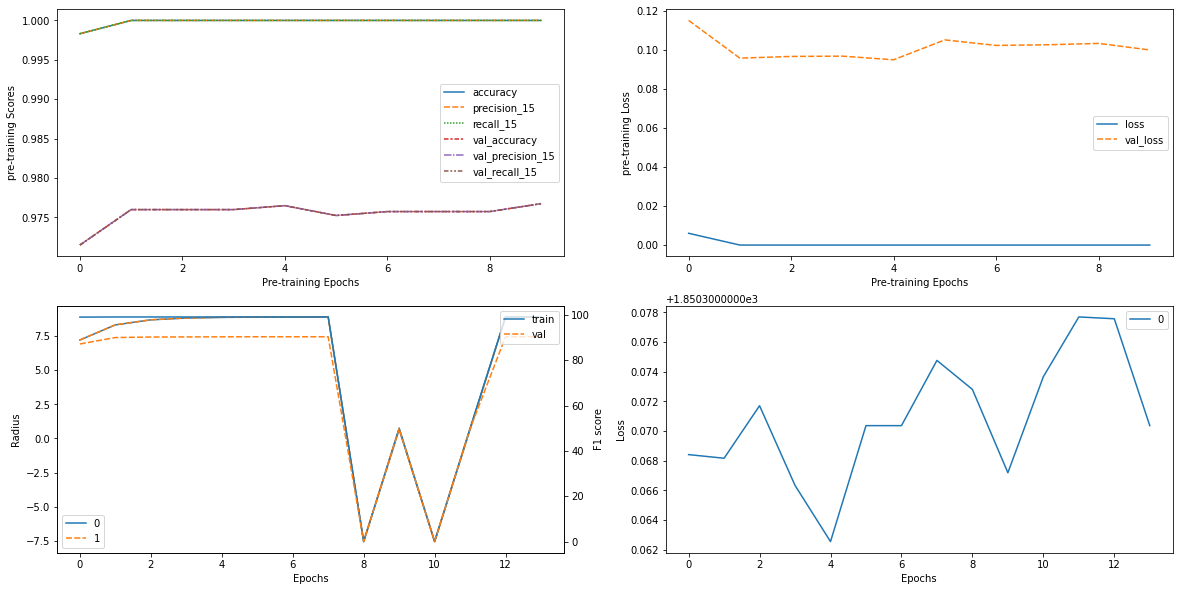

[[1997    0    0]
 [   4  530 1464]
 [   0    7  158]]
64.54
f1_weighted: 0.6874122631201527, f1_macro: 0.5313260456091439, f1_micro: 0.6454326923076923, f_measure: {'Known': 70.8573, 'Open': 17.6833, 'F1-score': 53.1326}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1997
           1       0.99      0.27      0.42      1998
           5       0.10      0.96      0.18       165

    accuracy                           0.65      4160
   macro avg       0.69      0.74      0.53      4160
weighted avg       0.96      0.65      0.69      4160



In [17]:
comment="decrease pretrain with 20K"
test_data, oset, hist = oset_train(ablation=20000,designated_ukc_cls=5,num_classes=2,embedding_size=16,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)

In [ ]:
comment="decrease pretrain with 20K"
test_data, oset, hist = oset_train(ablation=20000,designated_ukc_cls=5,num_classes=2,embedding_size=16,
                             lr_rate=2.6, optimizer='adam',
pretrain_epochs=10, wait_patience=8, comment=comment)